In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import graphviz
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import List

In [2]:
def load_and_merge_pdm(
    telemetry_path: str,
    errors_path: str,
    maint_path: str,
    failures_path: str,
    machines_path: str,
    *,
    floor_to_hour: bool = True,
    errors_as_counts: bool = True,
    maint_binary: bool = True,
    failures_binary: bool = True,
    include_maint_type_split: bool = True,
    corrective_window_hours: int = 6,
    include_model_onehot: bool = False,
    drop_raw_model: bool = False,
    telemetry_float_dtype: str = "float32",
    scale_continuous: bool = True,
) -> pd.DataFrame:

    def scale_continuous_features(df: pd.DataFrame, continuous_columns: List[str]) -> pd.DataFrame:
        scaler = StandardScaler()
        df[continuous_columns] = scaler.fit_transform(df[continuous_columns])
        return df

    tele = pd.read_csv(telemetry_path)
    errs = pd.read_csv(errors_path)
    maint = pd.read_csv(maint_path)
    fails = pd.read_csv(failures_path)
    machines = pd.read_csv(machines_path)

    if scale_continuous is True:
        tele = scale_continuous_features(tele, ['volt', 'rotate', 'pressure', 'vibration'])

    for df in (tele, errs, maint, fails):
        df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
        if floor_to_hour:
            df["datetime"] = df["datetime"].dt.floor("h")

    base = tele.merge(machines, on="machineID", how="left")
    for c in ["volt", "rotate", "pressure", "vibration"]:
        if c in base.columns:
            base[c] = base[c].astype(telemetry_float_dtype)

    if include_model_onehot and "model" in base.columns:
        dummies = pd.get_dummies(base["model"], prefix="model", dtype=np.int8)
        base = pd.concat([base, dummies], axis=1)
        if drop_raw_model:
            base = base.drop(columns=["model"])

    base = base.sort_values(["machineID", "datetime"])
    base_idx = base.set_index(["machineID", "datetime"])

    if not errs.empty:
        err_counts = errs.groupby(["machineID", "datetime", "errorID"]).size().reset_index(name="count")
        err_wide = err_counts.pivot_table(
            index=["machineID", "datetime"],
            columns="errorID",
            values="count",
            aggfunc="sum",
            fill_value=0,
        )
        for e in ["error1", "error2", "error3", "error4", "error5"]:
            if e not in err_wide.columns:
                err_wide[e] = 0
        err_wide = err_wide[["error1", "error2", "error3", "error4", "error5"]]
        err_wide = err_wide.astype(np.int16) if errors_as_counts else (err_wide > 0).astype(np.int8)
    else:
        err_wide = pd.DataFrame(index=base_idx.index)

    if not fails.empty:
        fail_counts = fails.groupby(["machineID", "datetime", "failure"]).size().reset_index(name="count")
        fail_wide = fail_counts.pivot_table(
            index=["machineID", "datetime"],
            columns="failure",
            values="count",
            aggfunc="sum",
            fill_value=0,
        )
        for c in ["comp1", "comp2", "comp3", "comp4"]:
            if c not in fail_wide.columns:
                fail_wide[c] = 0
        fail_wide = fail_wide[["comp1", "comp2", "comp3", "comp4"]]
        fail_wide = (fail_wide > 0).astype(np.int8) if failures_binary else fail_wide.astype(np.int16)
        fail_wide = fail_wide.add_prefix("fail_")
    else:
        fail_wide = pd.DataFrame(index=base_idx.index)

    if not maint.empty:
        m = maint.copy()

        if include_maint_type_split:
            f = fails.rename(columns={"failure": "comp"})[["machineID", "datetime", "comp"]].copy()
            f = f.rename(columns={"datetime": "failure_time"})

            m = m.sort_values(["datetime", "machineID", "comp"]).reset_index(drop=True)
            f = f.sort_values(["failure_time", "machineID", "comp"]).reset_index(drop=True)

            m2 = pd.merge_asof(
                m,
                f,
                left_on="datetime",
                right_on="failure_time",
                by=["machineID", "comp"],
                direction="backward",
                allow_exact_matches=True,
            )
            delta_h = (m2["datetime"] - m2["failure_time"]).dt.total_seconds() / 3600.0
            m2["maint_type"] = np.where(
                (~m2["failure_time"].isna()) & (delta_h >= 0) & (delta_h <= corrective_window_hours),
                "corr",
                "prev",
            )
            m = m2[["machineID", "datetime", "comp", "maint_type"]]
            types = ["prev", "corr"]
        else:
            m["maint_type"] = "all"
            m = m[["machineID", "datetime", "comp", "maint_type"]]
            types = ["all"]

        maint_counts = m.groupby(["machineID", "datetime", "maint_type", "comp"]).size().reset_index(name="count")
        maint_wide = maint_counts.pivot_table(
            index=["machineID", "datetime"],
            columns=["maint_type", "comp"],
            values="count",
            aggfunc="sum",
            fill_value=0,
        )

        maint_wide.columns = [f"maint_{t}_{c}" for (t, c) in maint_wide.columns]

        for t in types:
            for c in ["comp1", "comp2", "comp3", "comp4"]:
                col = f"maint_{t}_{c}"
                if col not in maint_wide.columns:
                    maint_wide[col] = 0

        maint_wide = maint_wide[[f"maint_{t}_{c}" for t in types for c in ["comp1","comp2","comp3","comp4"]]]
        maint_wide = (maint_wide > 0).astype(np.int8) if maint_binary else maint_wide.astype(np.int16)
    else:
        maint_wide = pd.DataFrame(index=base_idx.index)

    merged = base_idx.join(err_wide, how="left").join(maint_wide, how="left").join(fail_wide, how="left")
    merged = merged.fillna(0)

    event_cols: List[str] = []
    event_cols += [c for c in merged.columns if c in ["error1","error2","error3","error4","error5"]]
    event_cols += [c for c in merged.columns if c.startswith("maint_")]
    event_cols += [c for c in merged.columns if c.startswith("fail_")]
    for c in event_cols:
        if c.startswith("error") and errors_as_counts:
            merged[c] = merged[c].astype(np.int16)
        else:
            merged[c] = merged[c].astype(np.int8)

    merged = merged.reset_index().sort_values(["machineID", "datetime"]).reset_index(drop=True)
    return merged


def load_and_merge_pdm_from_dir(data_dir: str, **kwargs) -> pd.DataFrame:
    return load_and_merge_pdm(
        telemetry_path=os.path.join(data_dir, "PdM_telemetry.csv"),
        errors_path=os.path.join(data_dir, "PdM_errors.csv"),
        maint_path=os.path.join(data_dir, "PdM_maint.csv"),
        failures_path=os.path.join(data_dir, "PdM_failures.csv"),
        machines_path=os.path.join(data_dir, "PdM_machines.csv"),
        **kwargs,
    )


In [3]:
def visualize_data(
    telemetry_path: str,
    errors_path: str,
    failures_path: str,
    maint_path: str,
    machines_path: str,
    machine_model: str = None,
    failure_type: str = None,
    window_hours: int = 48,
    n_examples: int = 3,
    ylim_sigma: int = 5,
    smooth_window: int = 6,
    scale: bool = True
):
    print("Loading data...")
    tele = pd.read_csv(telemetry_path, parse_dates=["datetime"])
    errors = pd.read_csv(errors_path, parse_dates=["datetime"])
    fails = pd.read_csv(failures_path, parse_dates=["datetime"])
    maint = pd.read_csv(maint_path, parse_dates=["datetime"])
    machines = pd.read_csv(machines_path)

    if machine_model:
        target_mids = machines[machines["model"] == machine_model]["machineID"]
        fails = fails[fails["machineID"].isin(target_mids)]
    
    if failure_type:
        fails = fails[fails["failure"] == failure_type]

    if fails.empty:
        print("No failures found.")
        return

    sample_failures = fails.sample(n=min(n_examples, len(fails)), random_state=12345678)
    sensor_cols = ["volt", "rotate", "pressure", "vibration"]

    for idx, row in sample_failures.iterrows():
        mid = row["machineID"]
        fail_dt = row["datetime"]
        fail_comp = row["failure"]
        model = machines[machines["machineID"]==mid]["model"].values[0]

        # get full history
        machine_tele = tele[tele["machineID"] == mid].copy().sort_values("datetime")
        
        # calculate stats for this specific machine
        stats = {}
        for col in sensor_cols:
            mu = machine_tele[col].mean()
            sigma = machine_tele[col].std()
            stats[col] = {'mean': mu, 'std': sigma}
            
            if scale:
                machine_tele[col] = (machine_tele[col] - mu) / sigma

            machine_tele[f"{col}_smooth"] = machine_tele[col].rolling(window=smooth_window, center=True).mean()

        # slice window
        start_time = fail_dt - pd.Timedelta(hours=window_hours)
        end_time = fail_dt + pd.Timedelta(hours=window_hours)
        
        window_tele = machine_tele[machine_tele["datetime"].between(start_time, end_time)]
        window_errors = errors[(errors["machineID"] == mid) & (errors["datetime"].between(start_time, end_time))]
        window_maint = maint[(maint["machineID"] == mid) & (maint["datetime"].between(start_time, end_time))]

        if window_tele.empty: continue

        unit_label = "Z-Score" if scale else "Raw Units"
        fig, axes = plt.subplots(4, 1, figsize=(25, 15), sharex=True)
        fig.suptitle(
            f"Machine {mid} ({model}): {fail_comp} at {fail_dt}\n"
            f"Scale: {unit_label} (Fixed +/- {ylim_sigma}σ) | Trend: {smooth_window}h Avg", 
            fontsize=16
        )

        for i, sensor in enumerate(sensor_cols):
            ax = axes[i]
            
            sns.lineplot(data=window_tele, x="datetime", y=sensor, ax=ax, color='gray', alpha=0.2, linewidth=0.8)
            sns.lineplot(data=window_tele, x="datetime", y=f"{sensor}_smooth", ax=ax, color='tab:blue', linewidth=2.5)
            
            center = 0 if scale else stats[sensor]['mean']
            std_dev = 1 if scale else stats[sensor]['std']
            
            lower_limit = center - (ylim_sigma * std_dev)
            upper_limit = center + (ylim_sigma * std_dev)
            
            ax.set_ylim(lower_limit, upper_limit)

            norm_lower = center - (2 * std_dev)
            norm_upper = center + (2 * std_dev)
            ax.axhspan(norm_lower, norm_upper, color='green', alpha=0.05, label="Normal (2σ)")
            ax.axhline(center, color='green', linestyle=':', alpha=0.5)

            six_ams = pd.date_range(start=start_time, end=end_time, freq="D") + pd.Timedelta(hours=6)
            for t in six_ams:
                ax.axvline(t, color='gray', linestyle=':', alpha=0.3)

            if not window_errors.empty:
                err_points = pd.merge_asof(
                    window_errors.sort_values('datetime'), 
                    window_tele[['datetime', f"{sensor}_smooth"]], 
                    on='datetime', direction='nearest'
                )
                
                ax.scatter(err_points['datetime'], err_points[f"{sensor}_smooth"], 
                           color='red', s=60, zorder=5, marker='X')

                for dt, group in err_points.groupby('datetime'):
                    y_val = group[f"{sensor}_smooth"].iloc[0]
                    if pd.notna(y_val) and lower_limit < y_val < upper_limit:
                        labels = sorted(group['errorID'].apply(lambda s: s.replace("error", "E")).unique())
                        label_text = " / ".join(labels)
                        
                        ax.text(
                            dt, y_val + (0.6 * std_dev),
                            label_text, 
                            color='red', fontweight='bold', fontsize=10, ha='center',
                            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
                        )

            for m_date in window_maint['datetime']:
                ax.axvline(m_date, color='green', linestyle='--', linewidth=2, label='Maint.')
            ax.axvline(fail_dt, color='red', linestyle='-', linewidth=2, label='FAILURE')

            ax.set_ylabel(f"{sensor.title()}\n({unit_label})")
            if i == 0:
                ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

        plt.tight_layout()
        plt.show()



=== Visualizing for model1 - comp1 ===
Loading data...


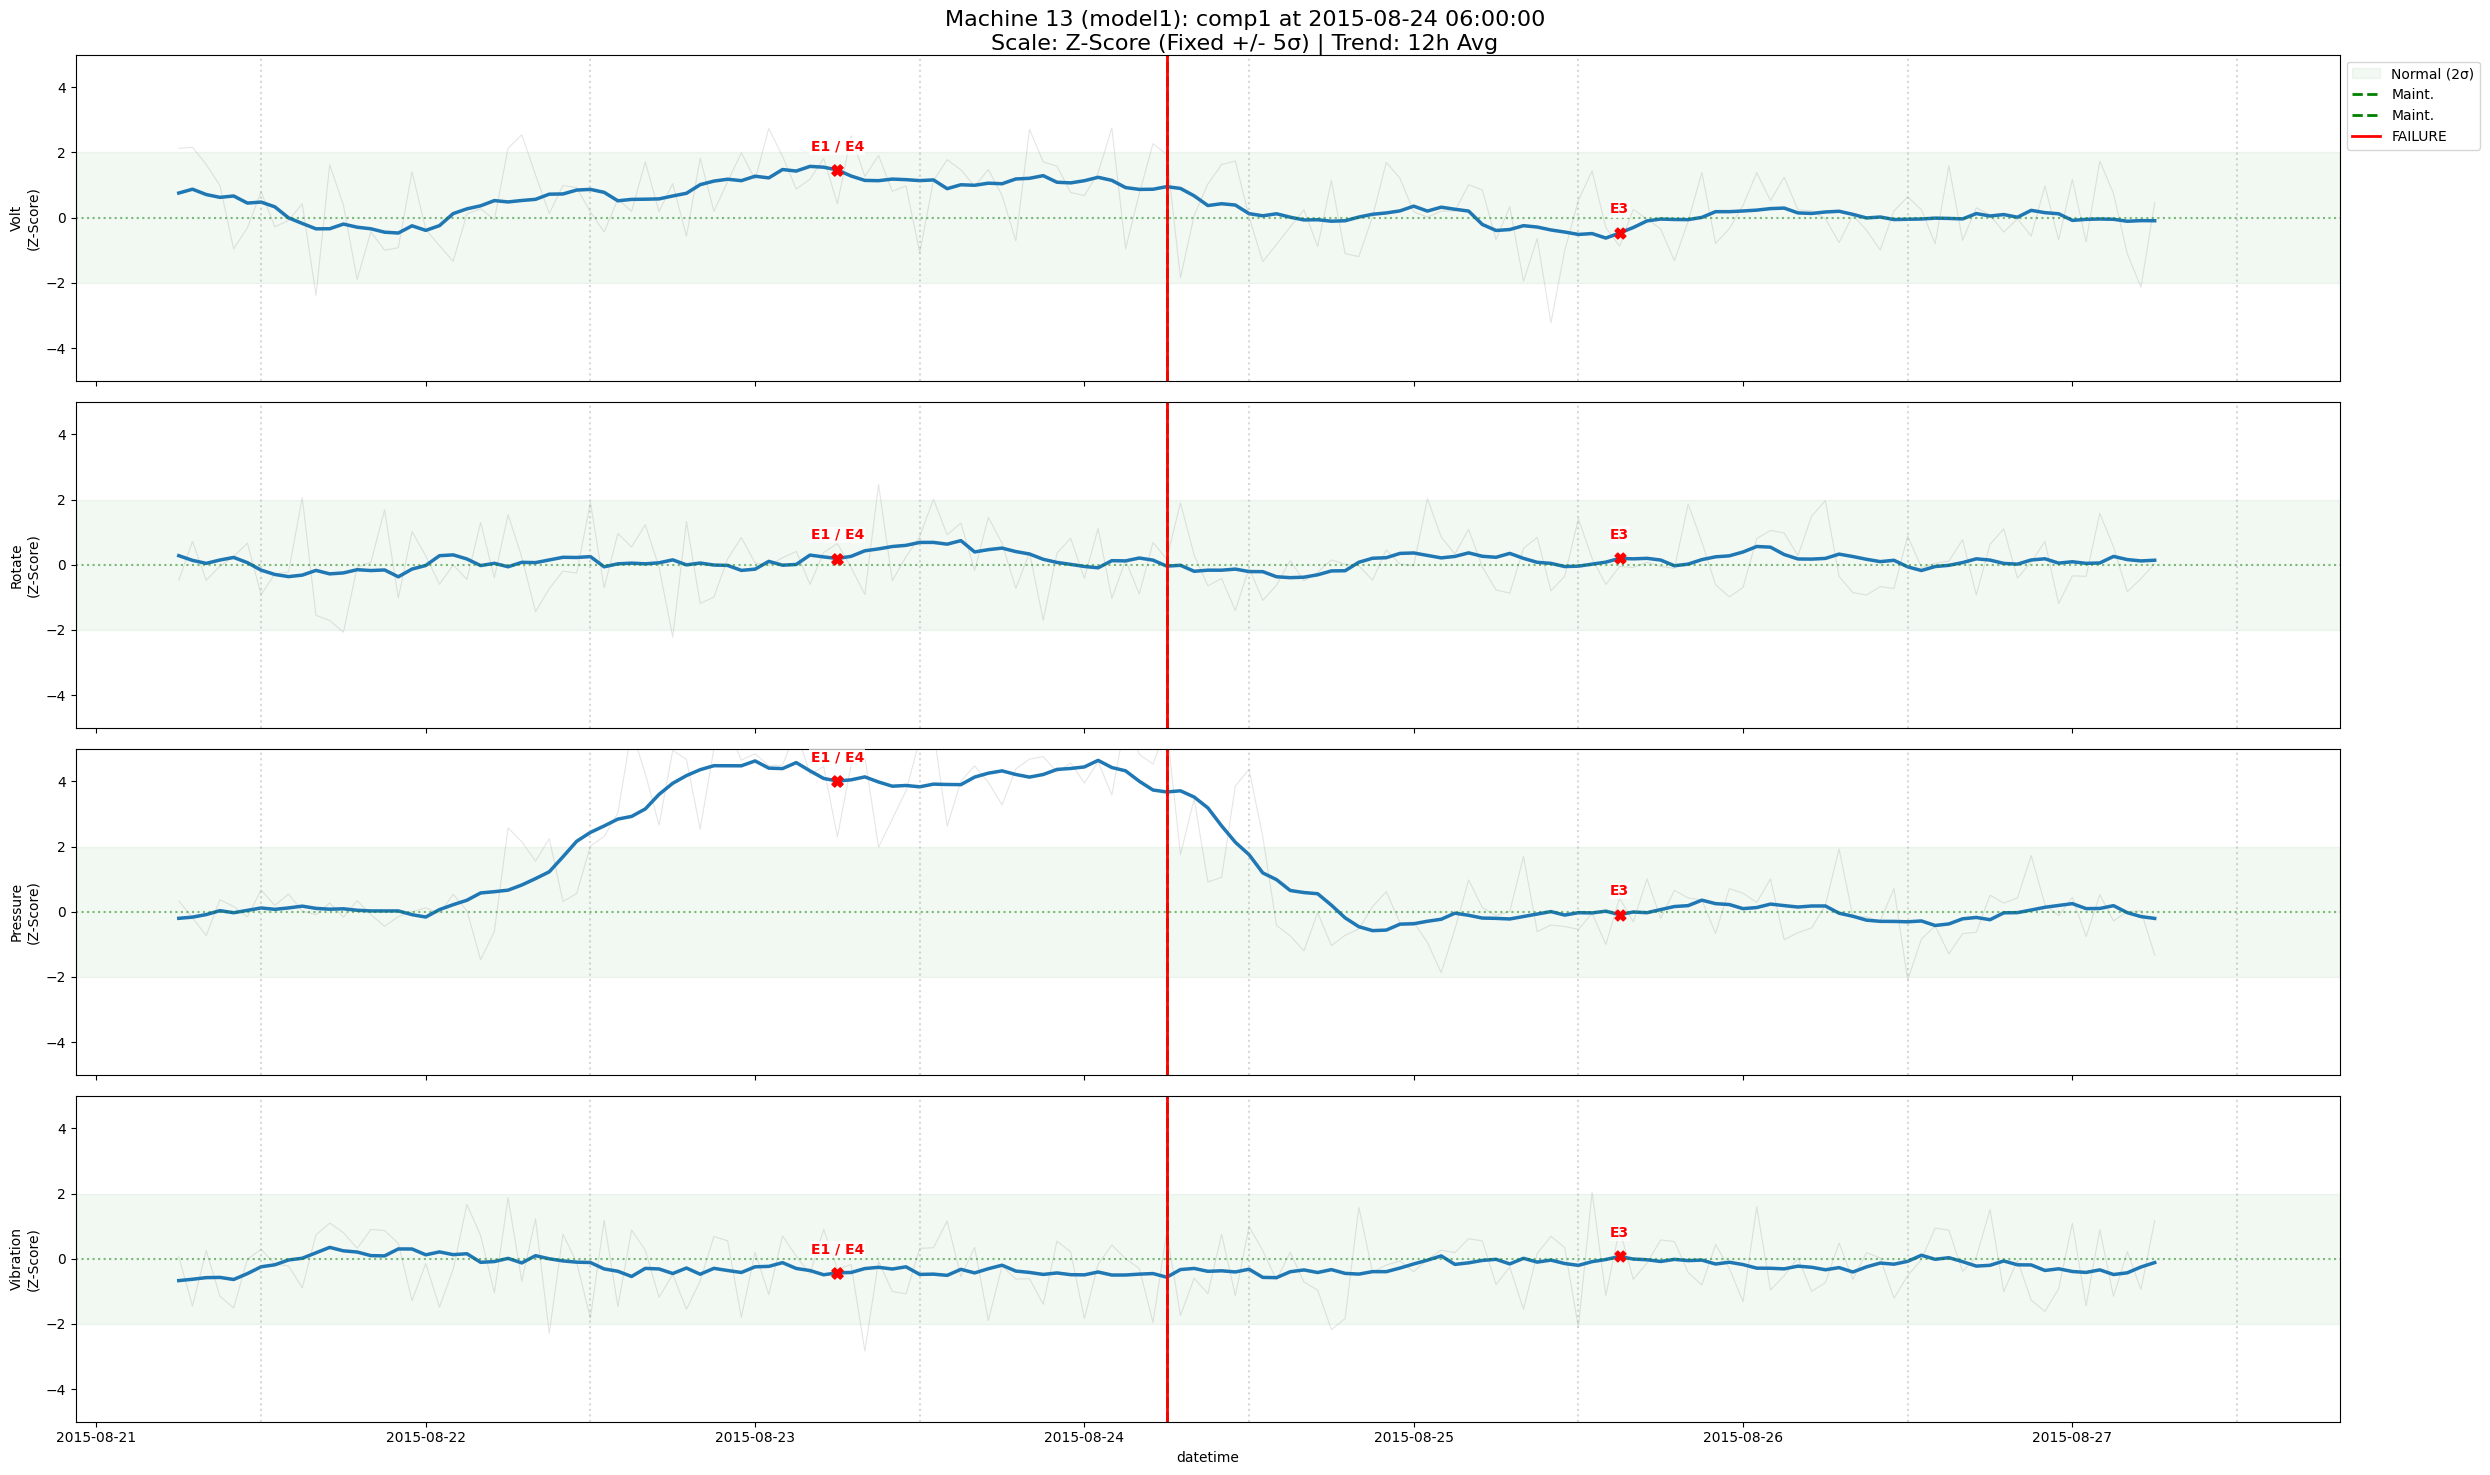



=== Visualizing for model1 - comp2 ===
Loading data...


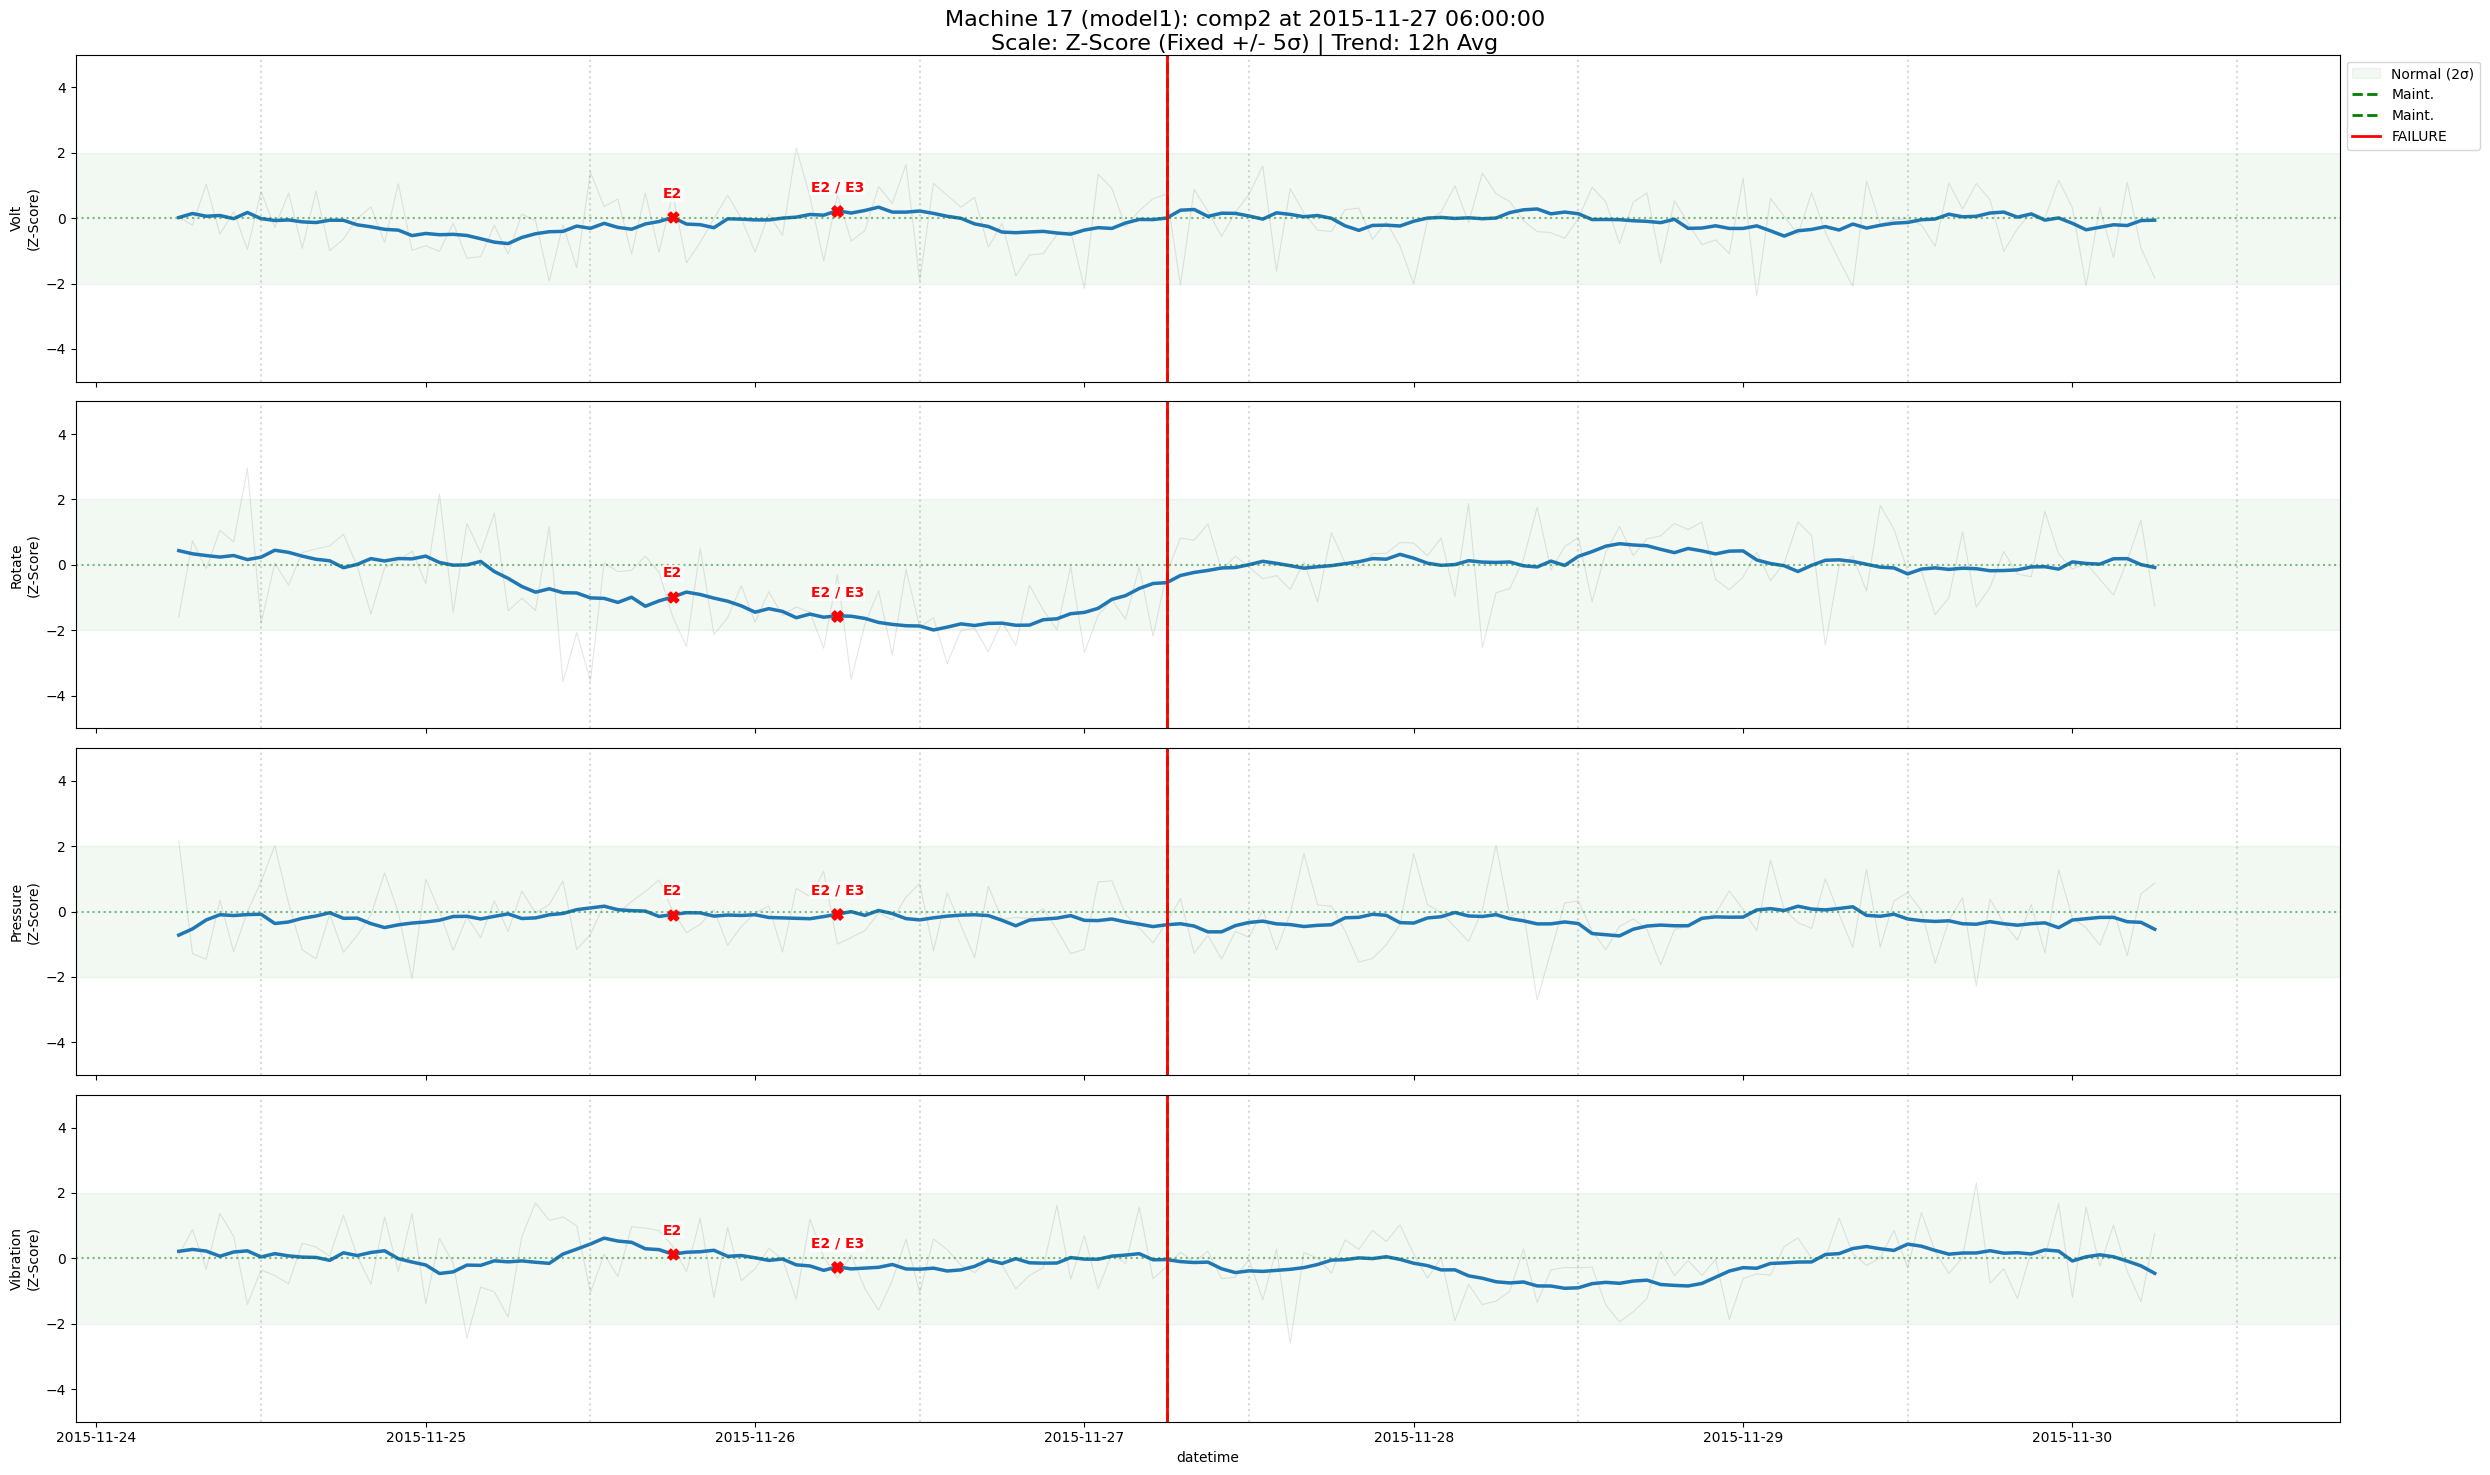



=== Visualizing for model1 - comp3 ===
Loading data...


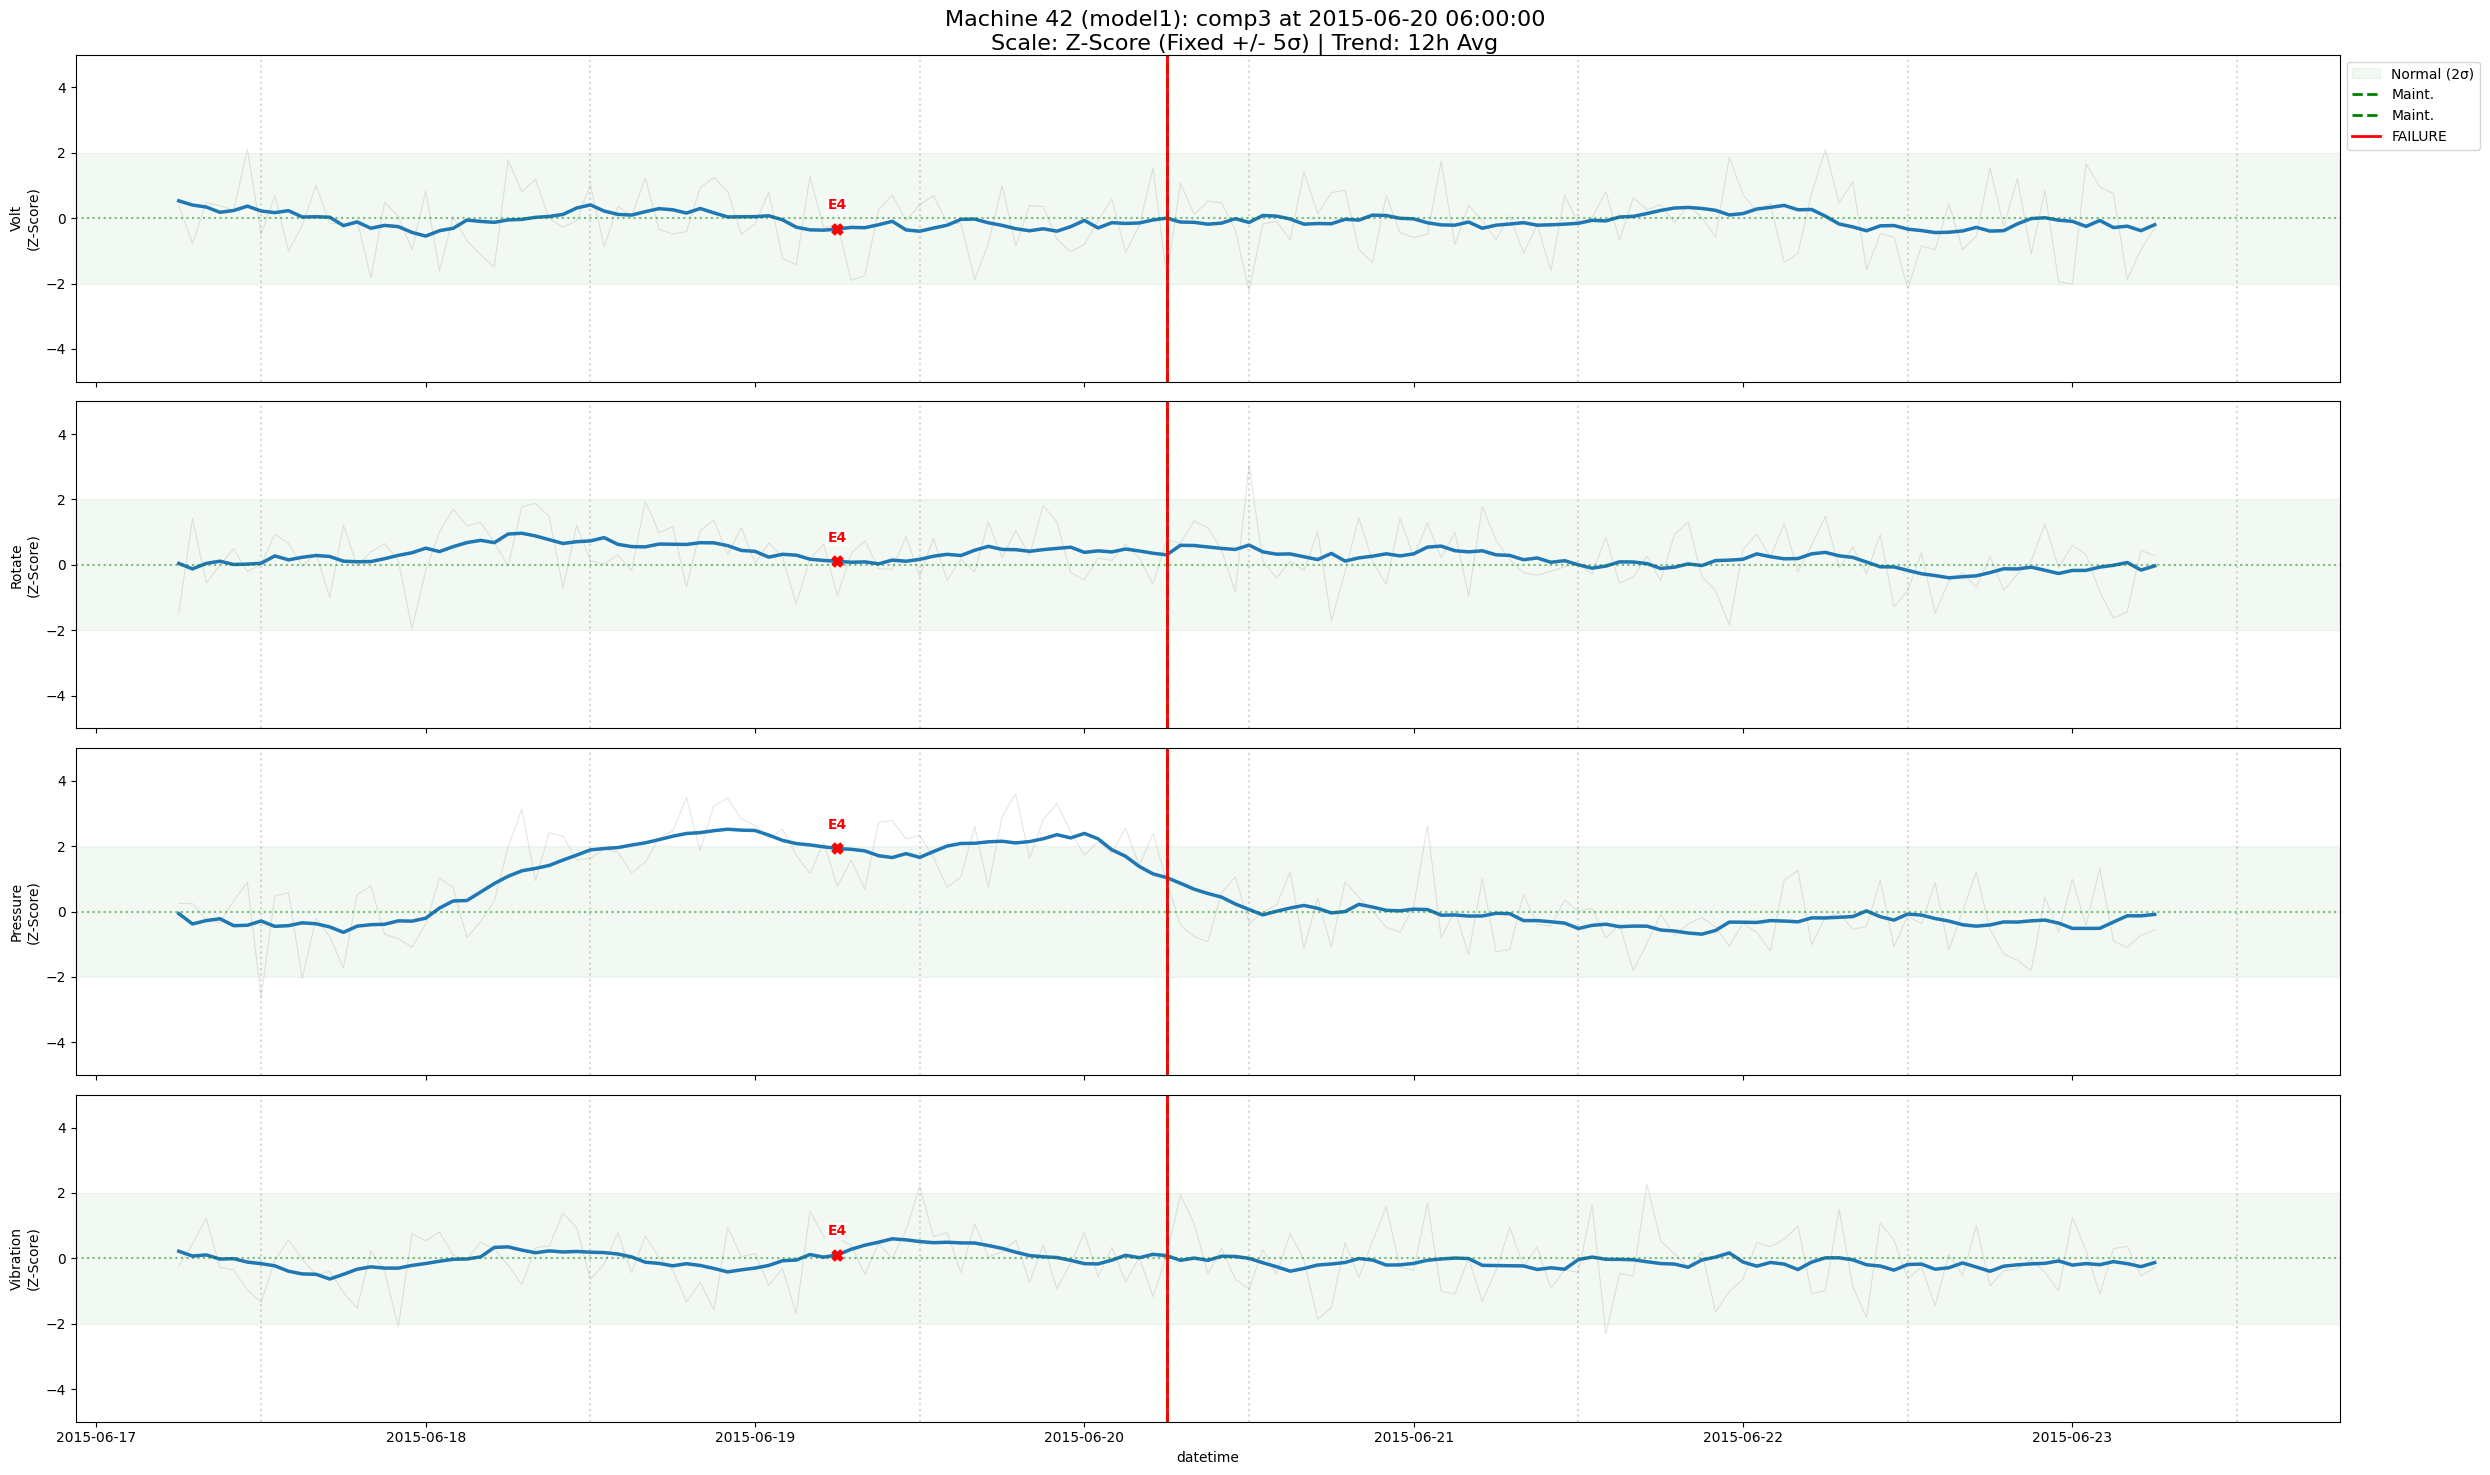



=== Visualizing for model1 - comp4 ===
Loading data...


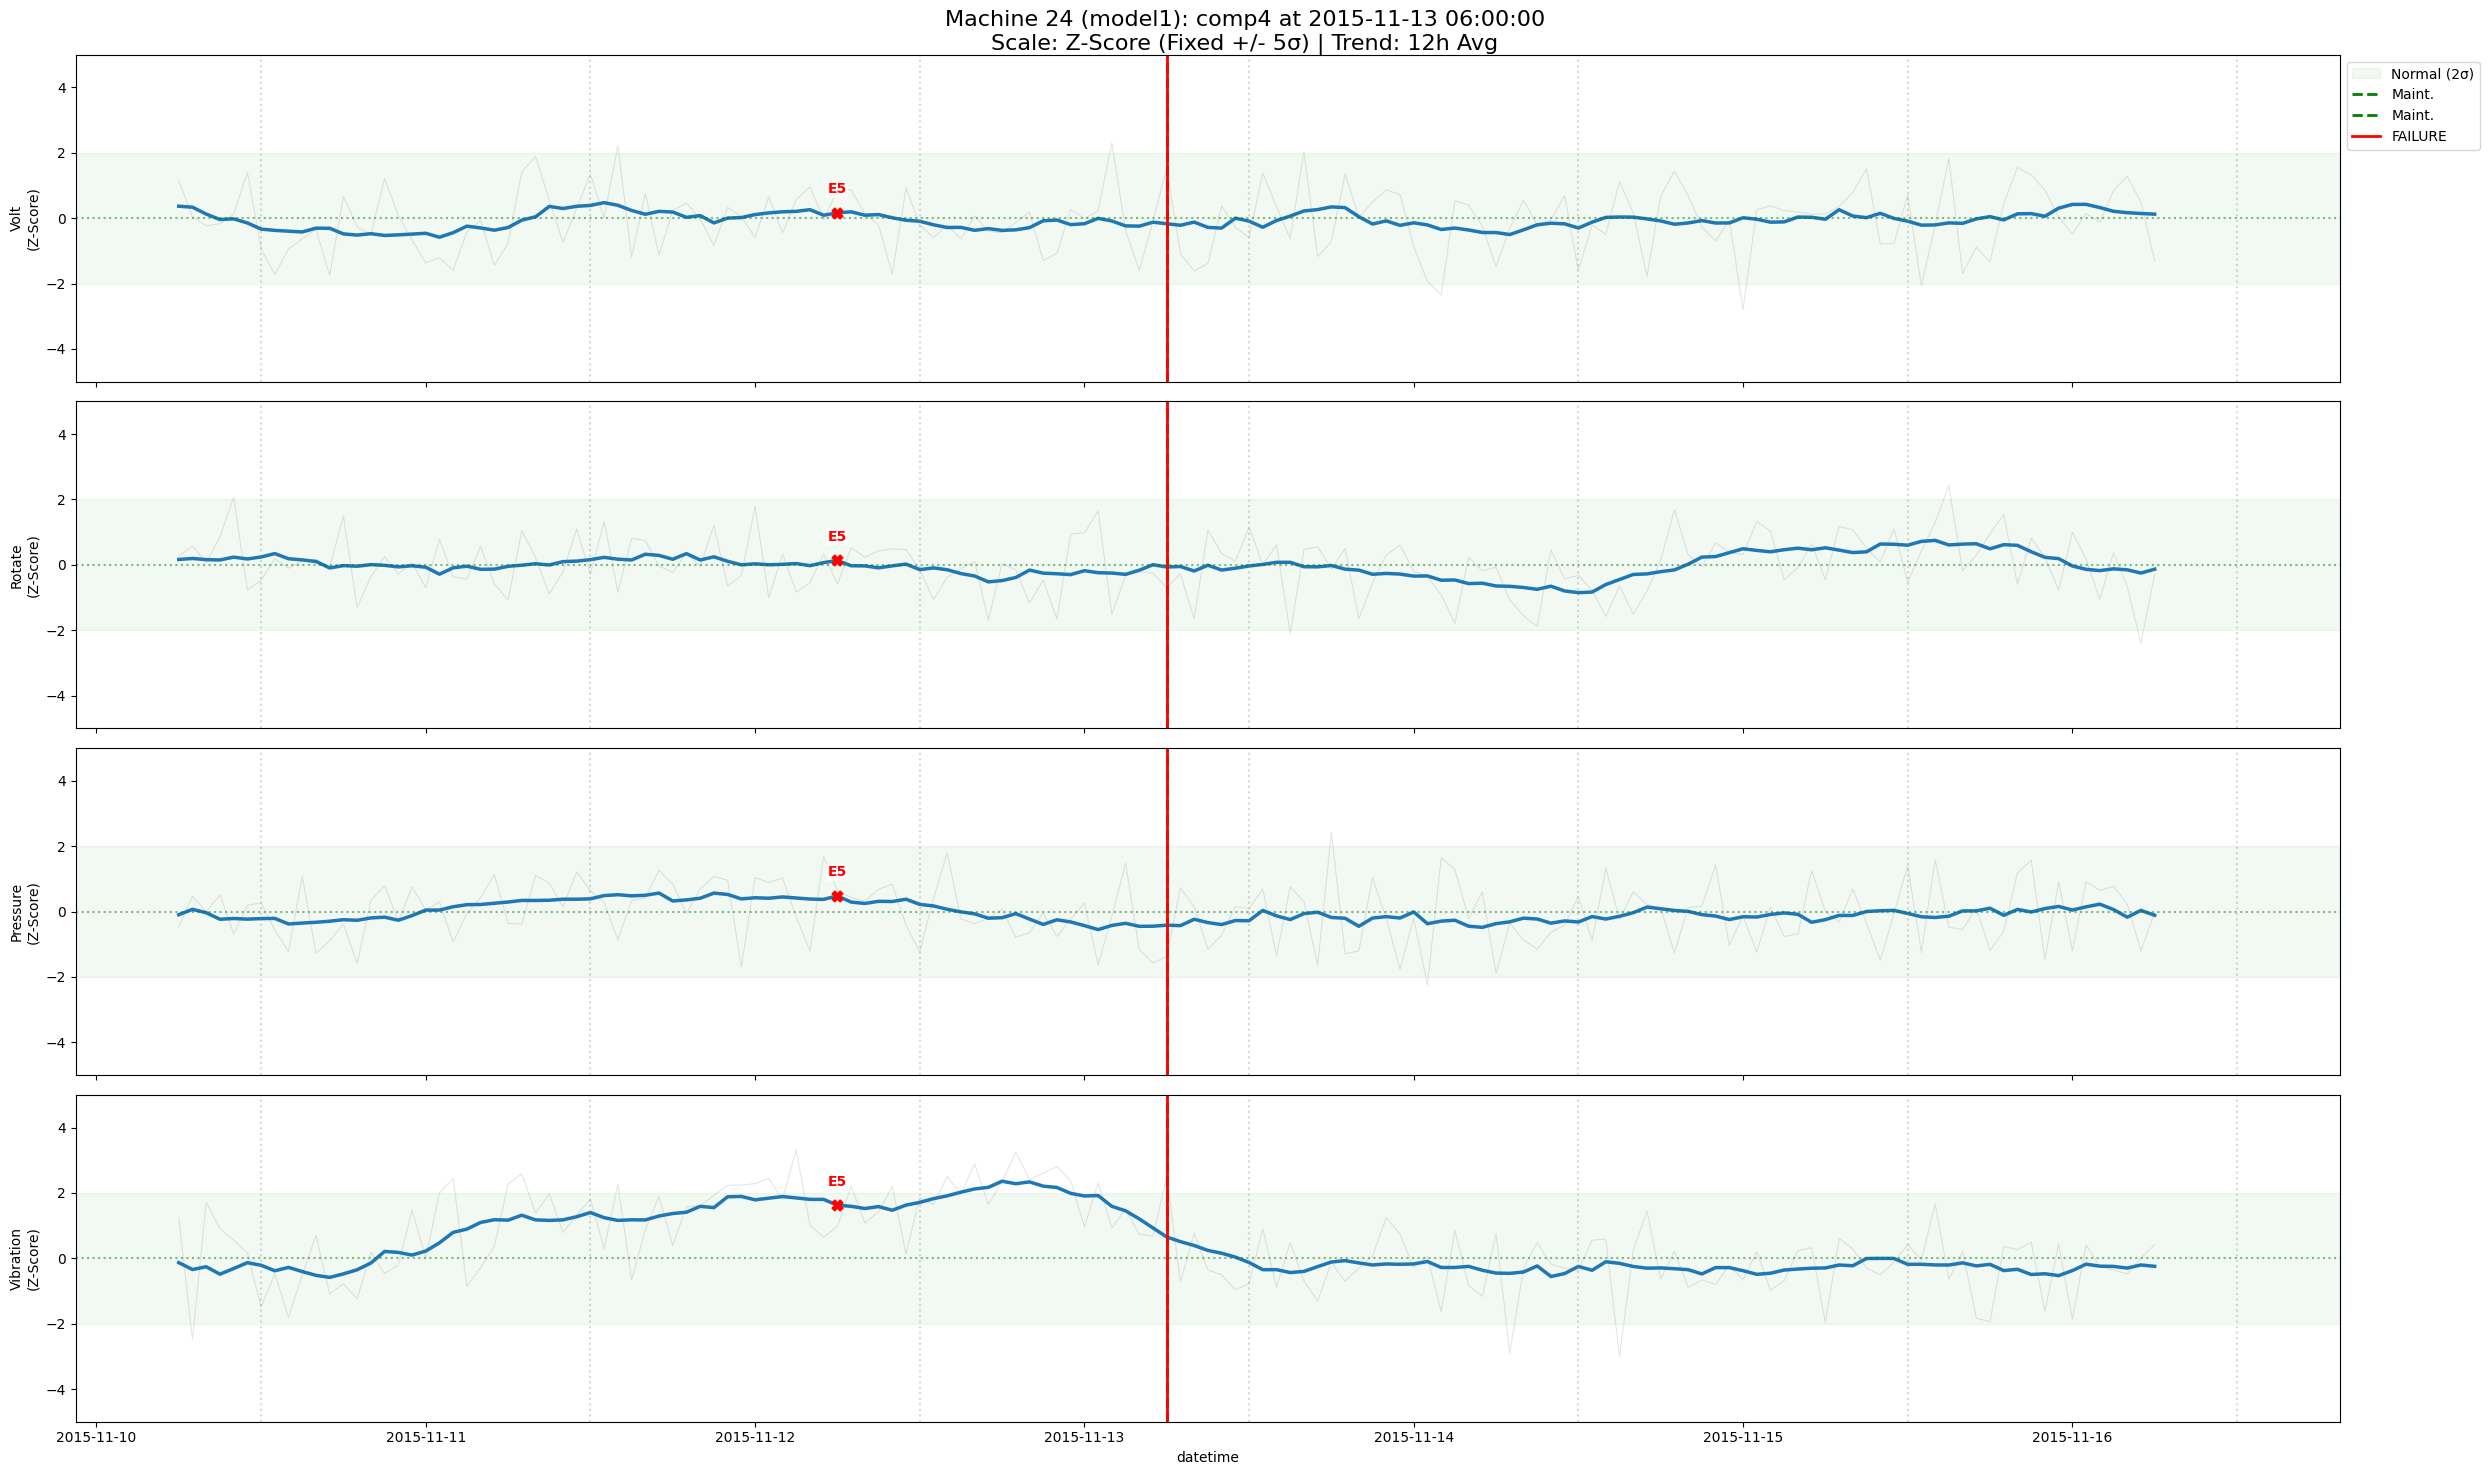



=== Visualizing for model2 - comp1 ===
Loading data...


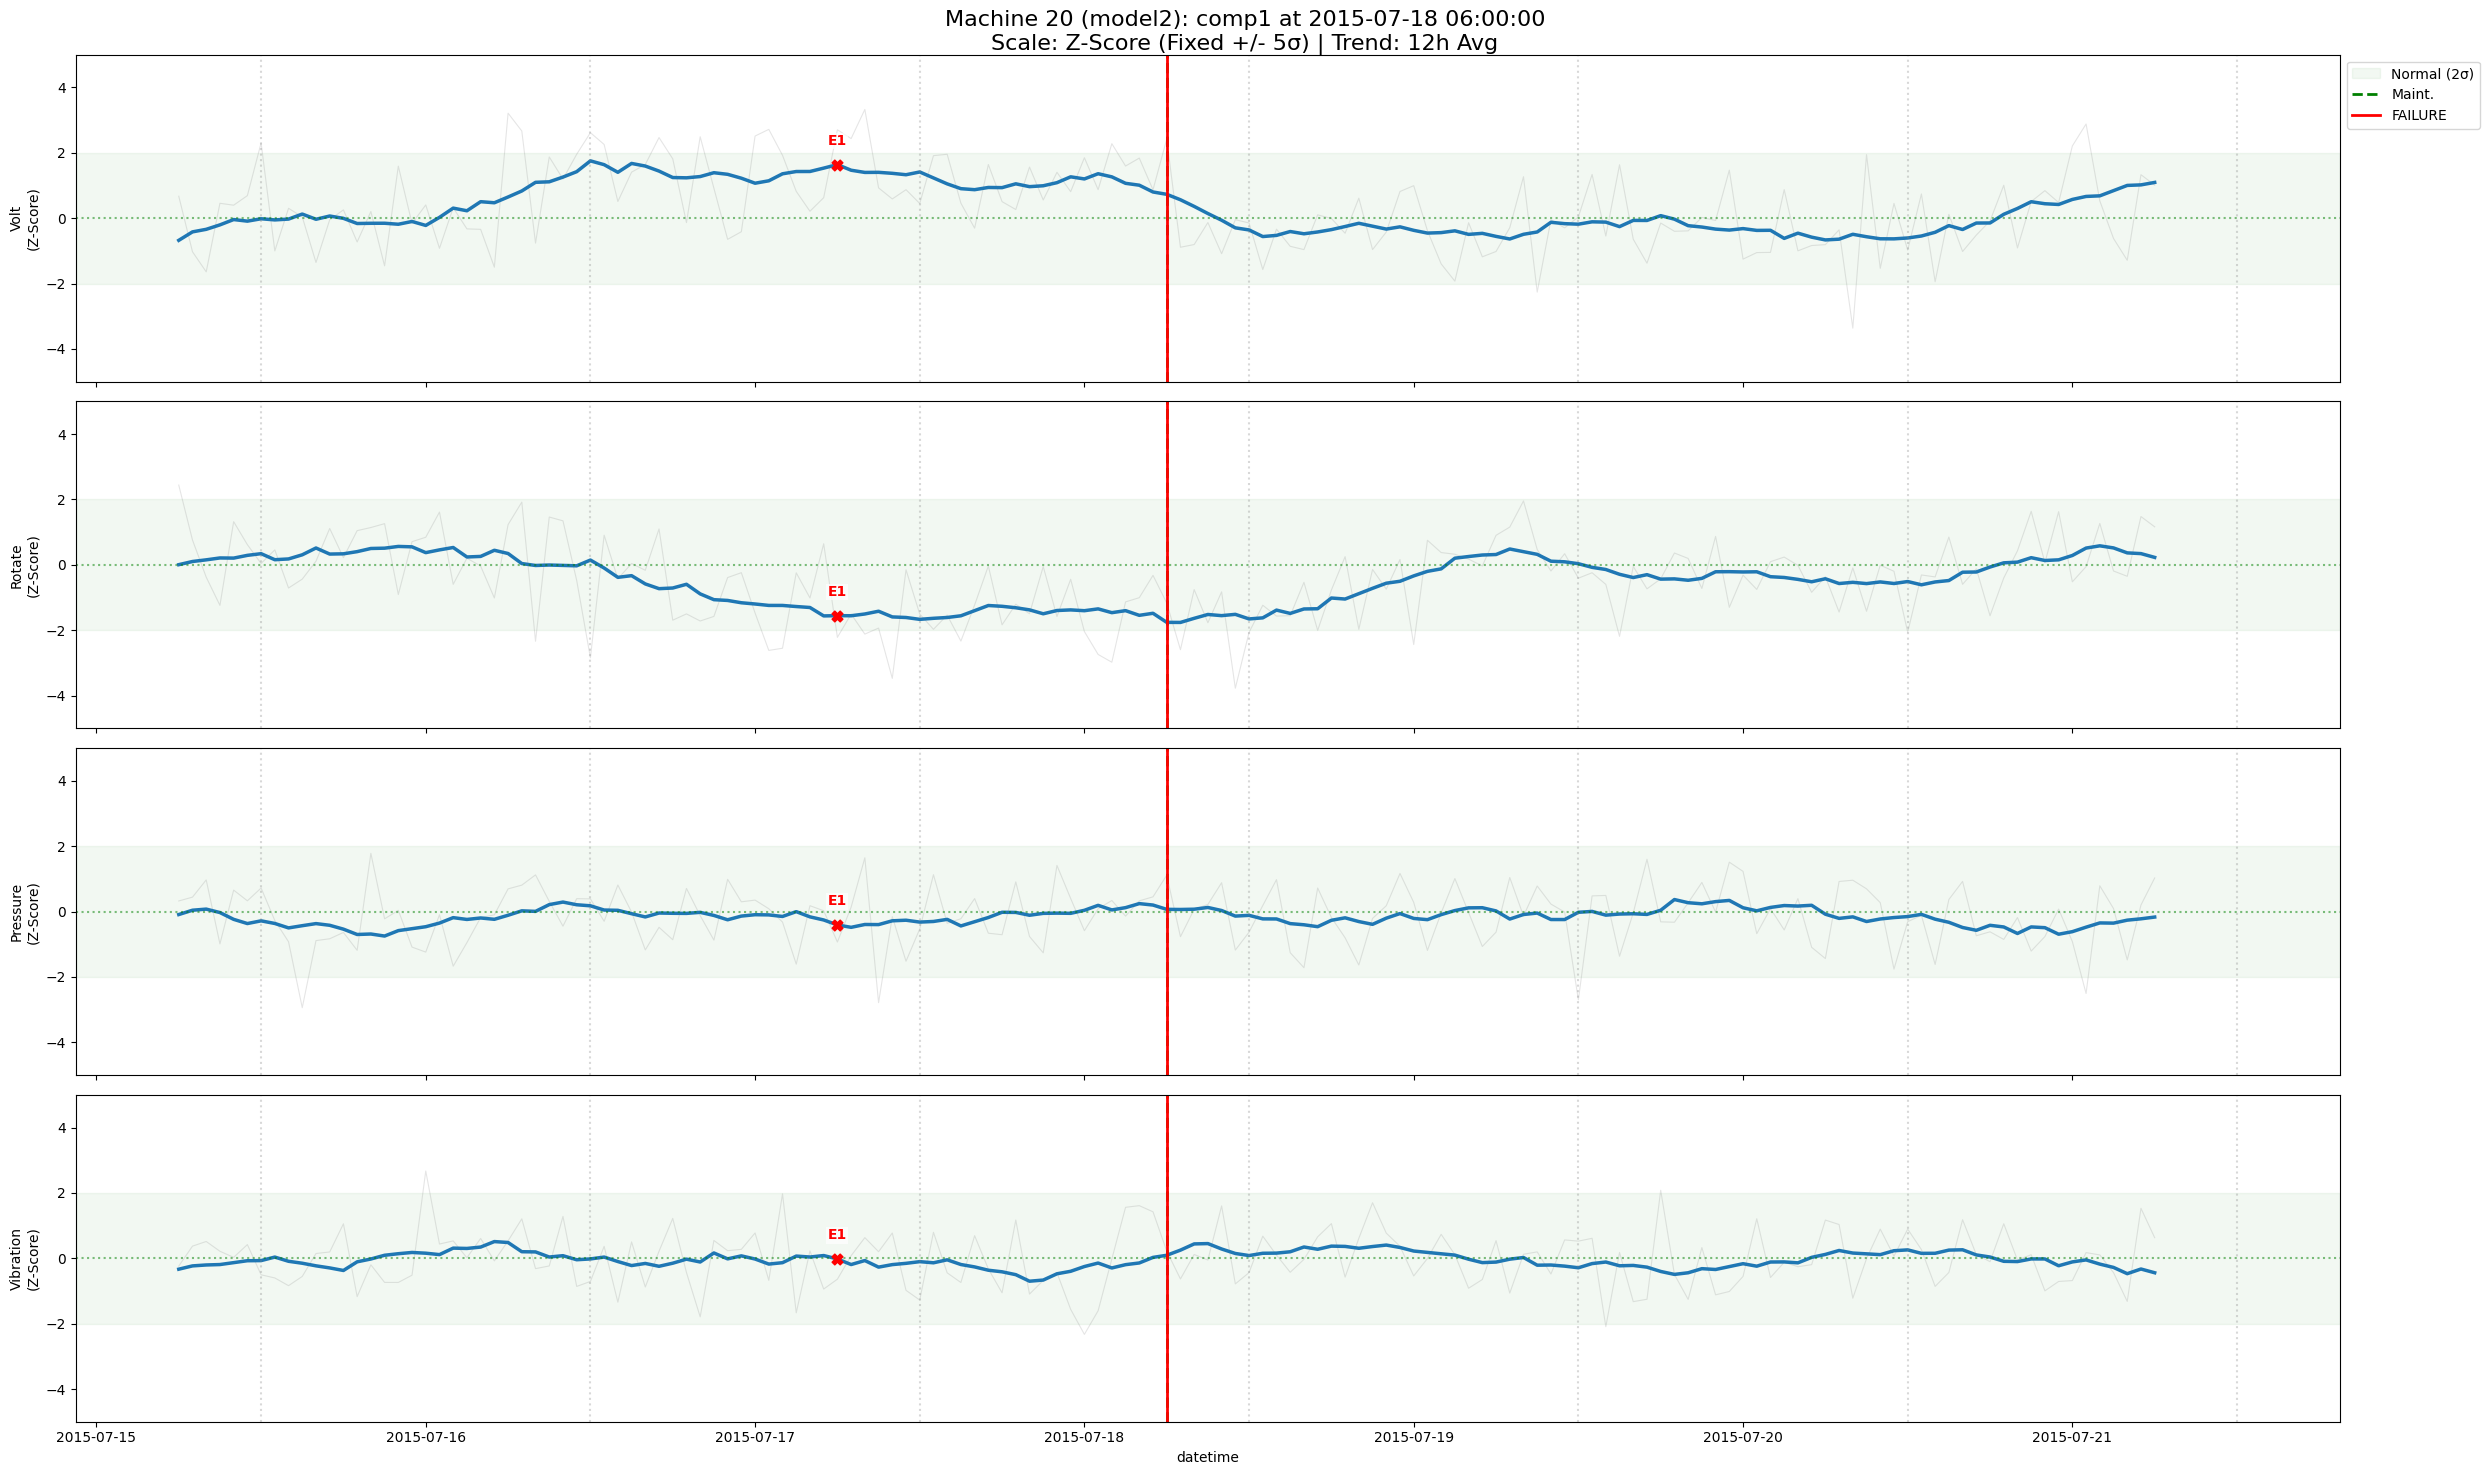



=== Visualizing for model2 - comp2 ===
Loading data...


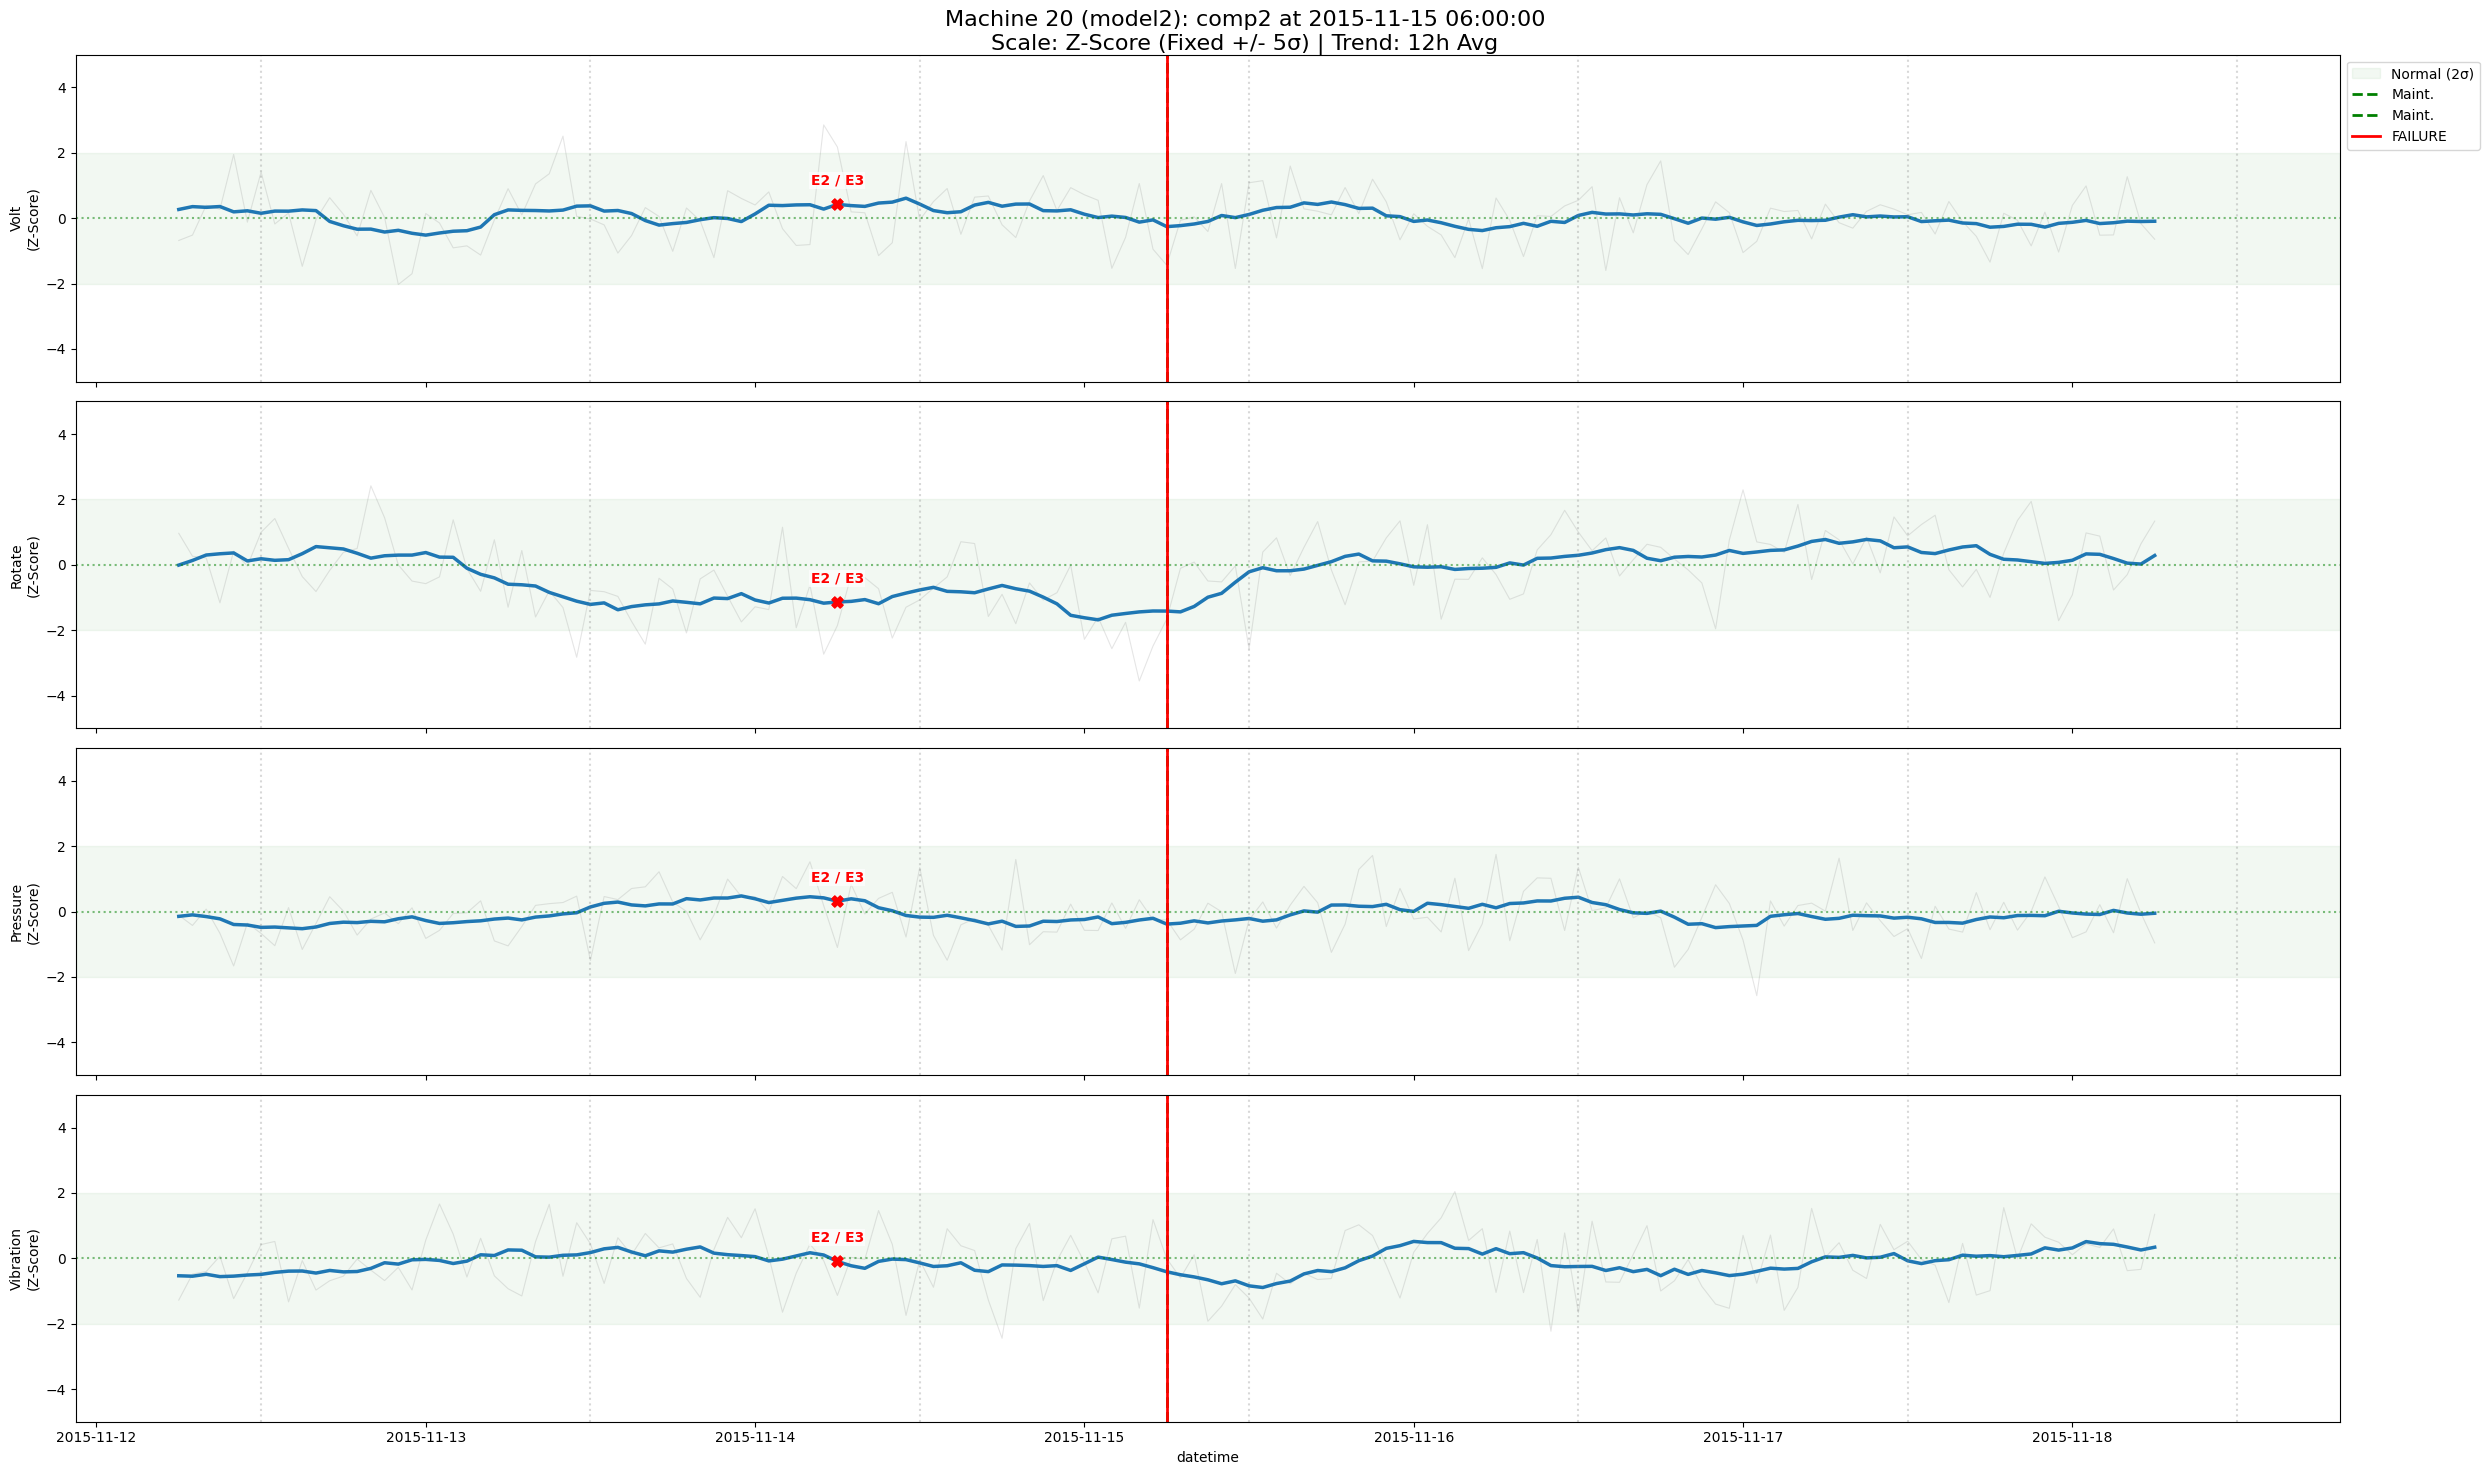



=== Visualizing for model2 - comp3 ===
Loading data...


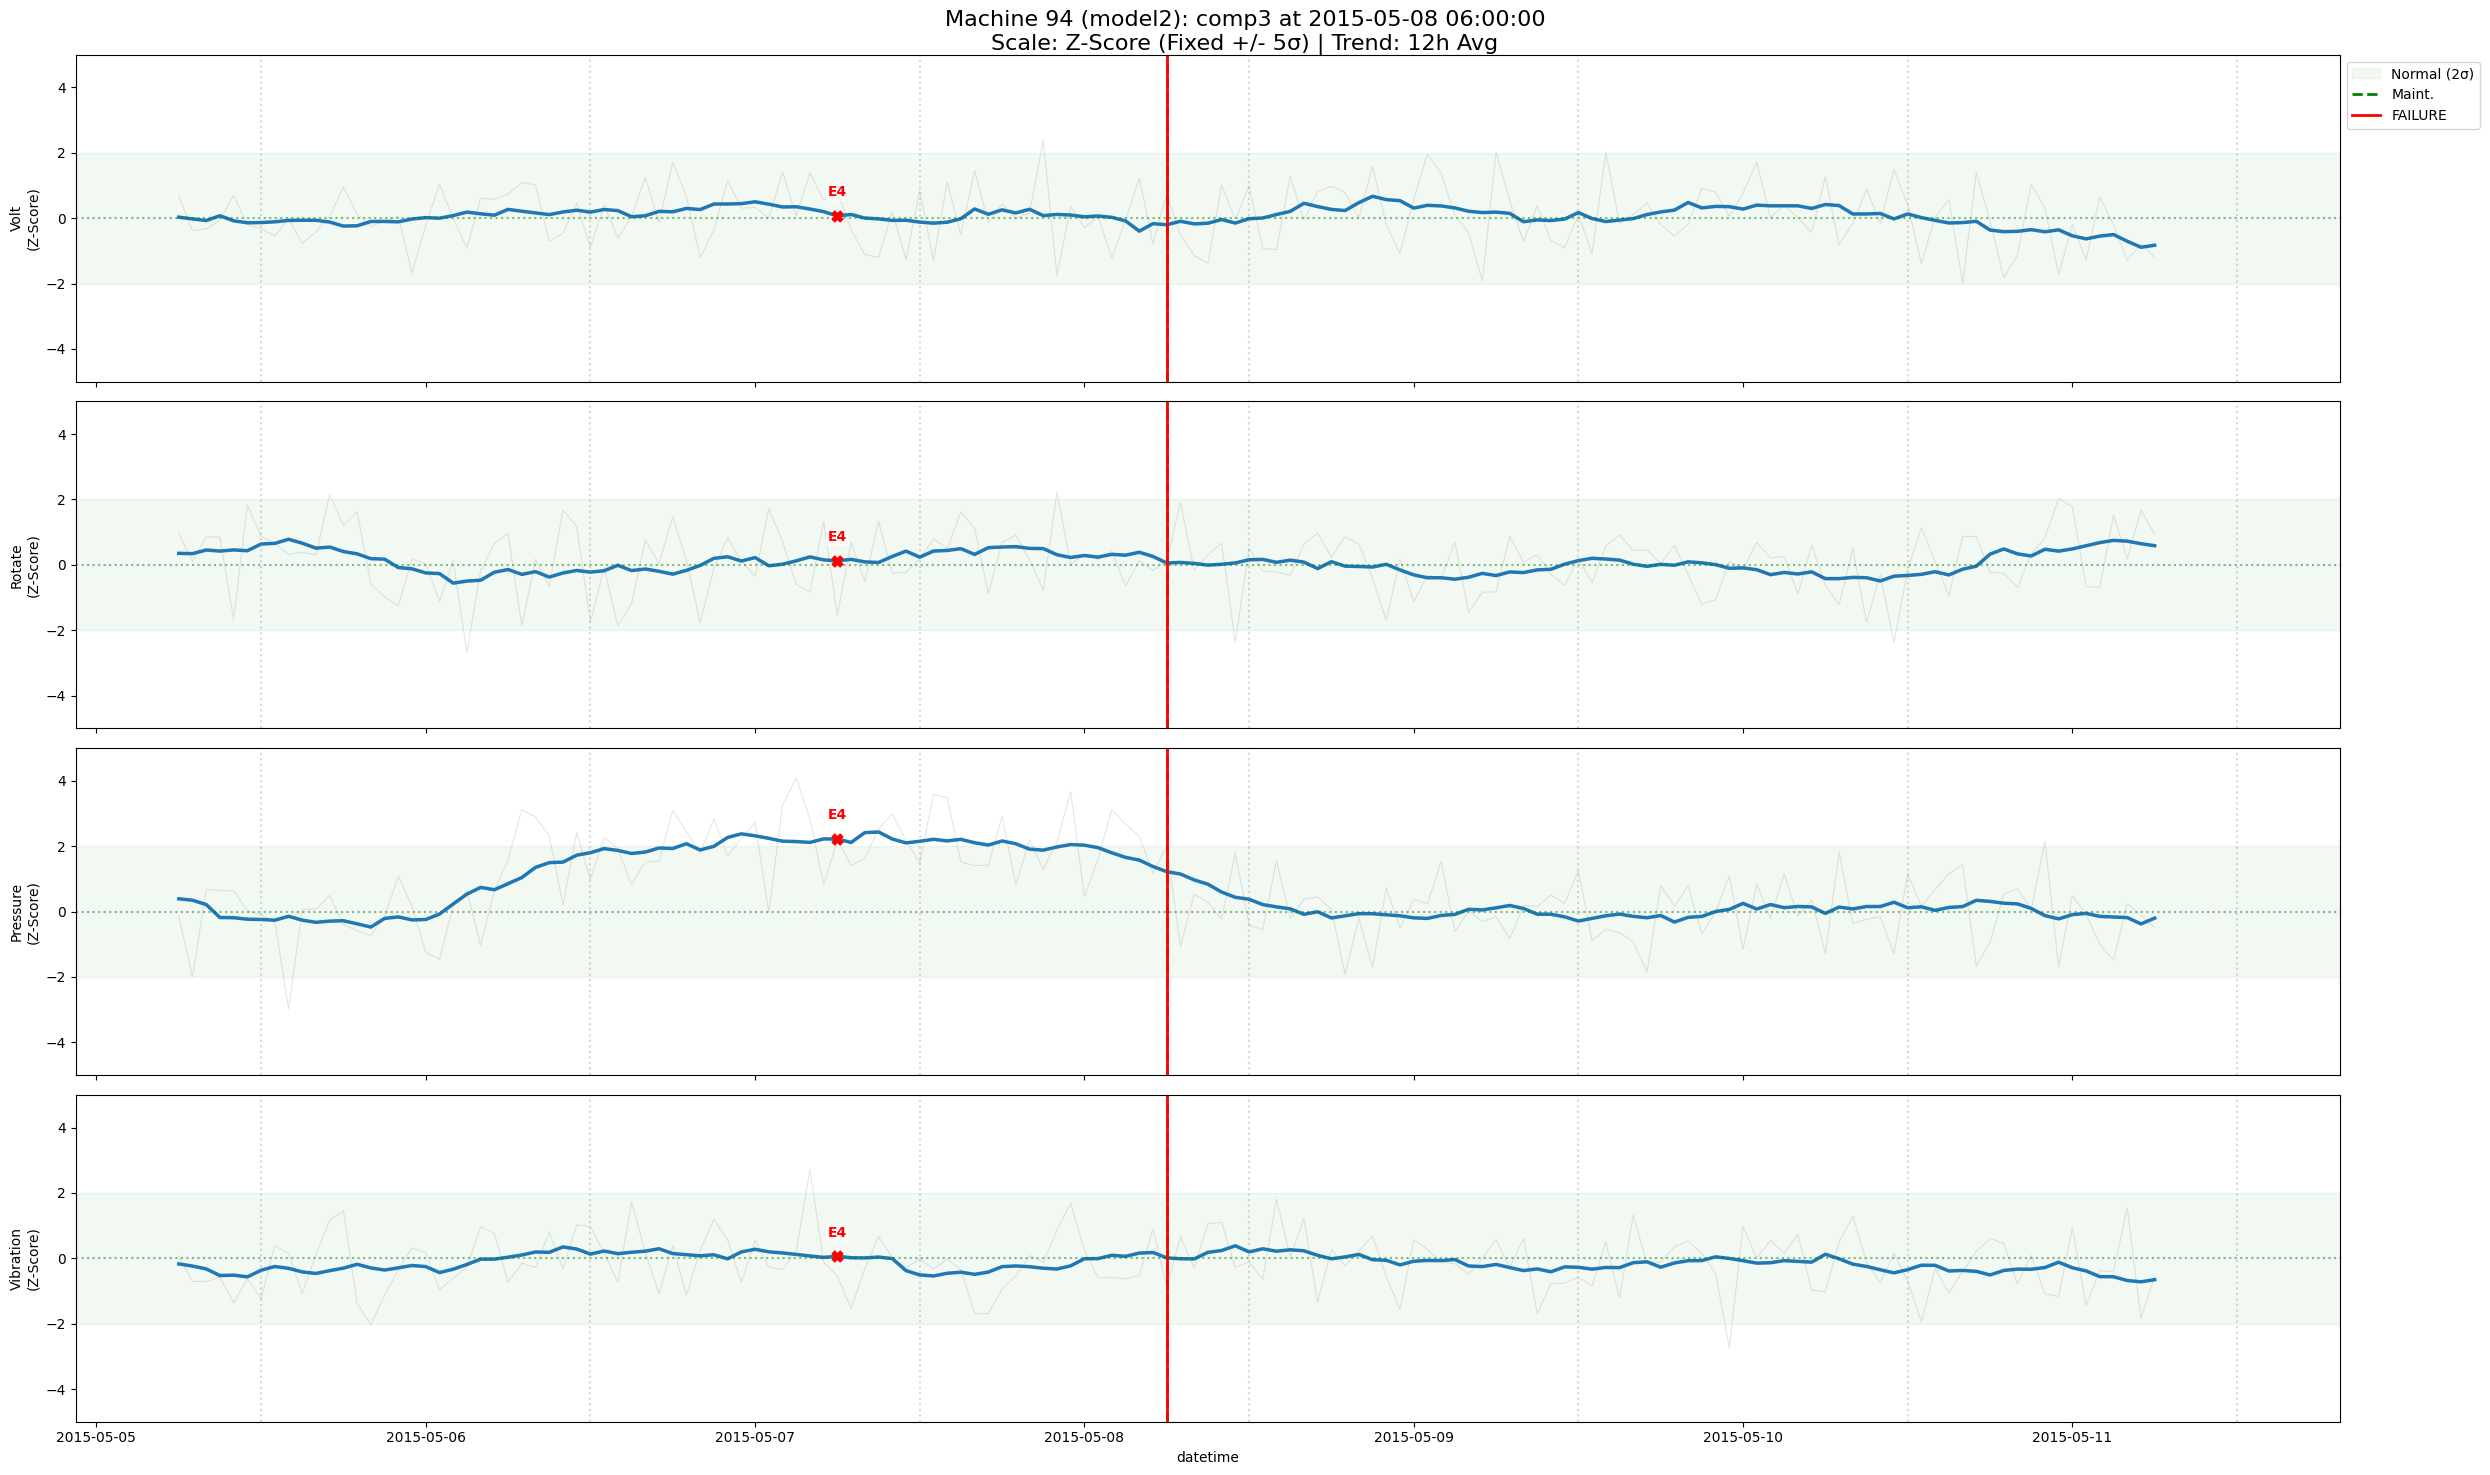



=== Visualizing for model2 - comp4 ===
Loading data...


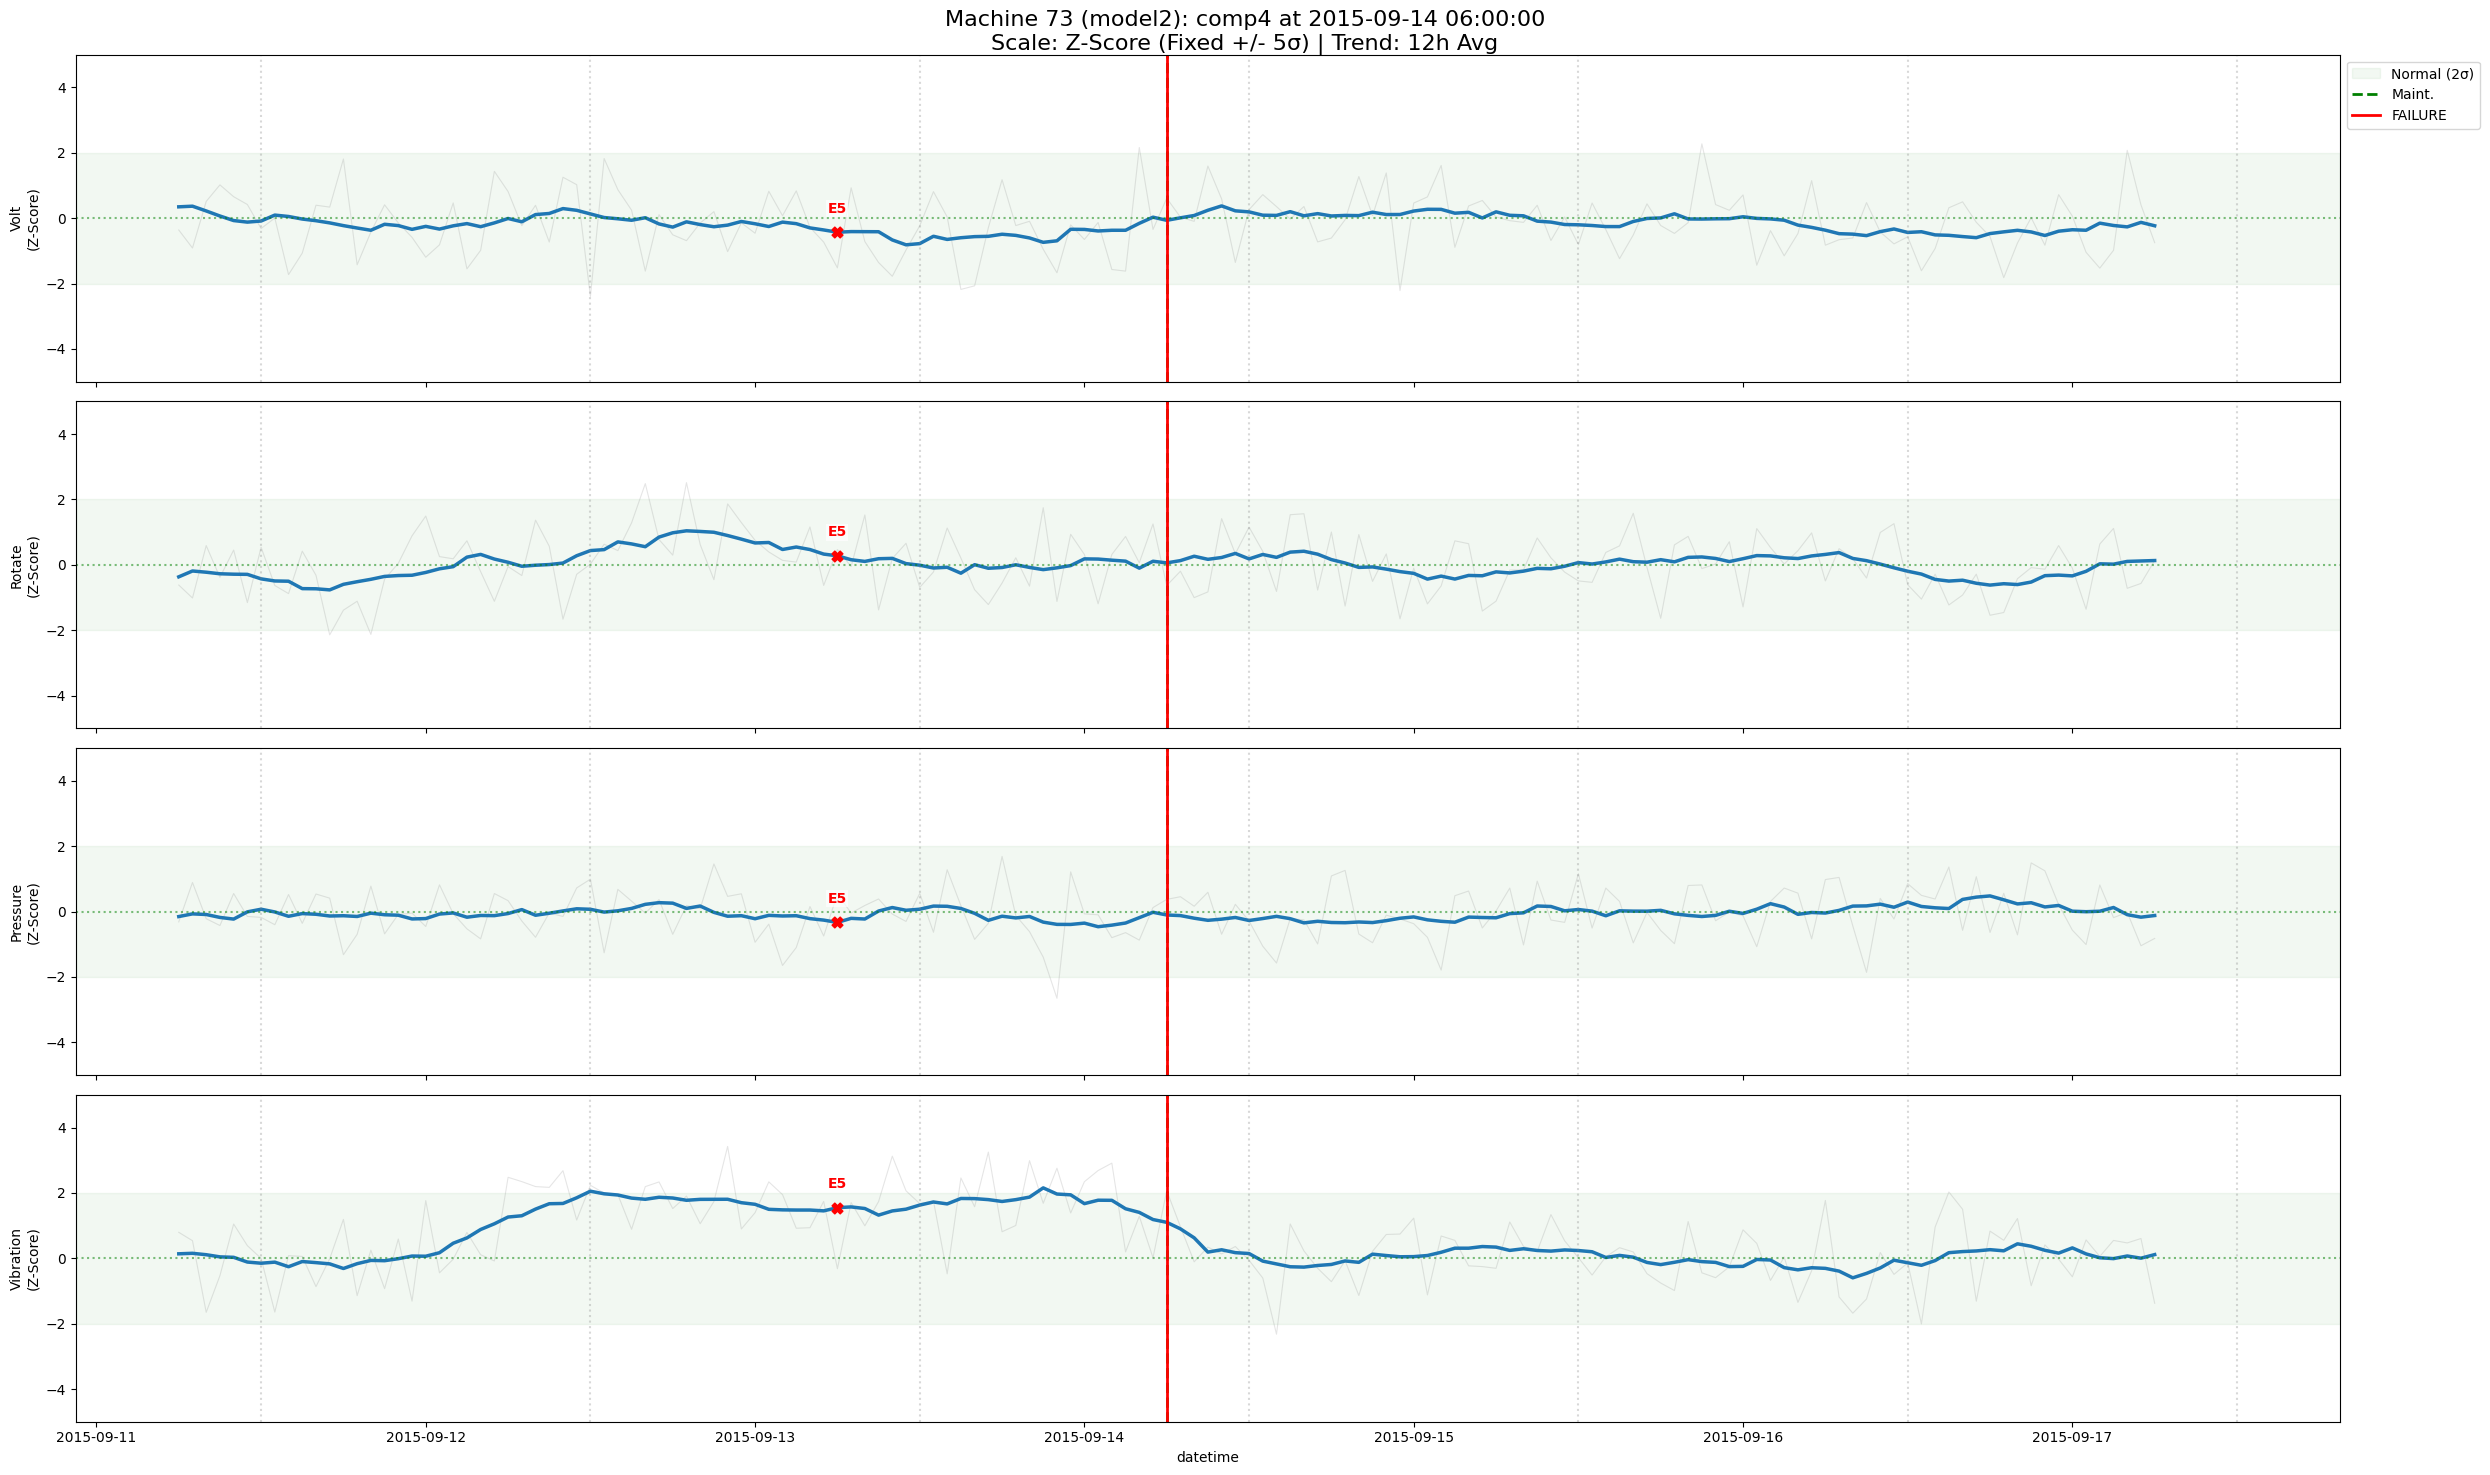



=== Visualizing for model3 - comp1 ===
Loading data...


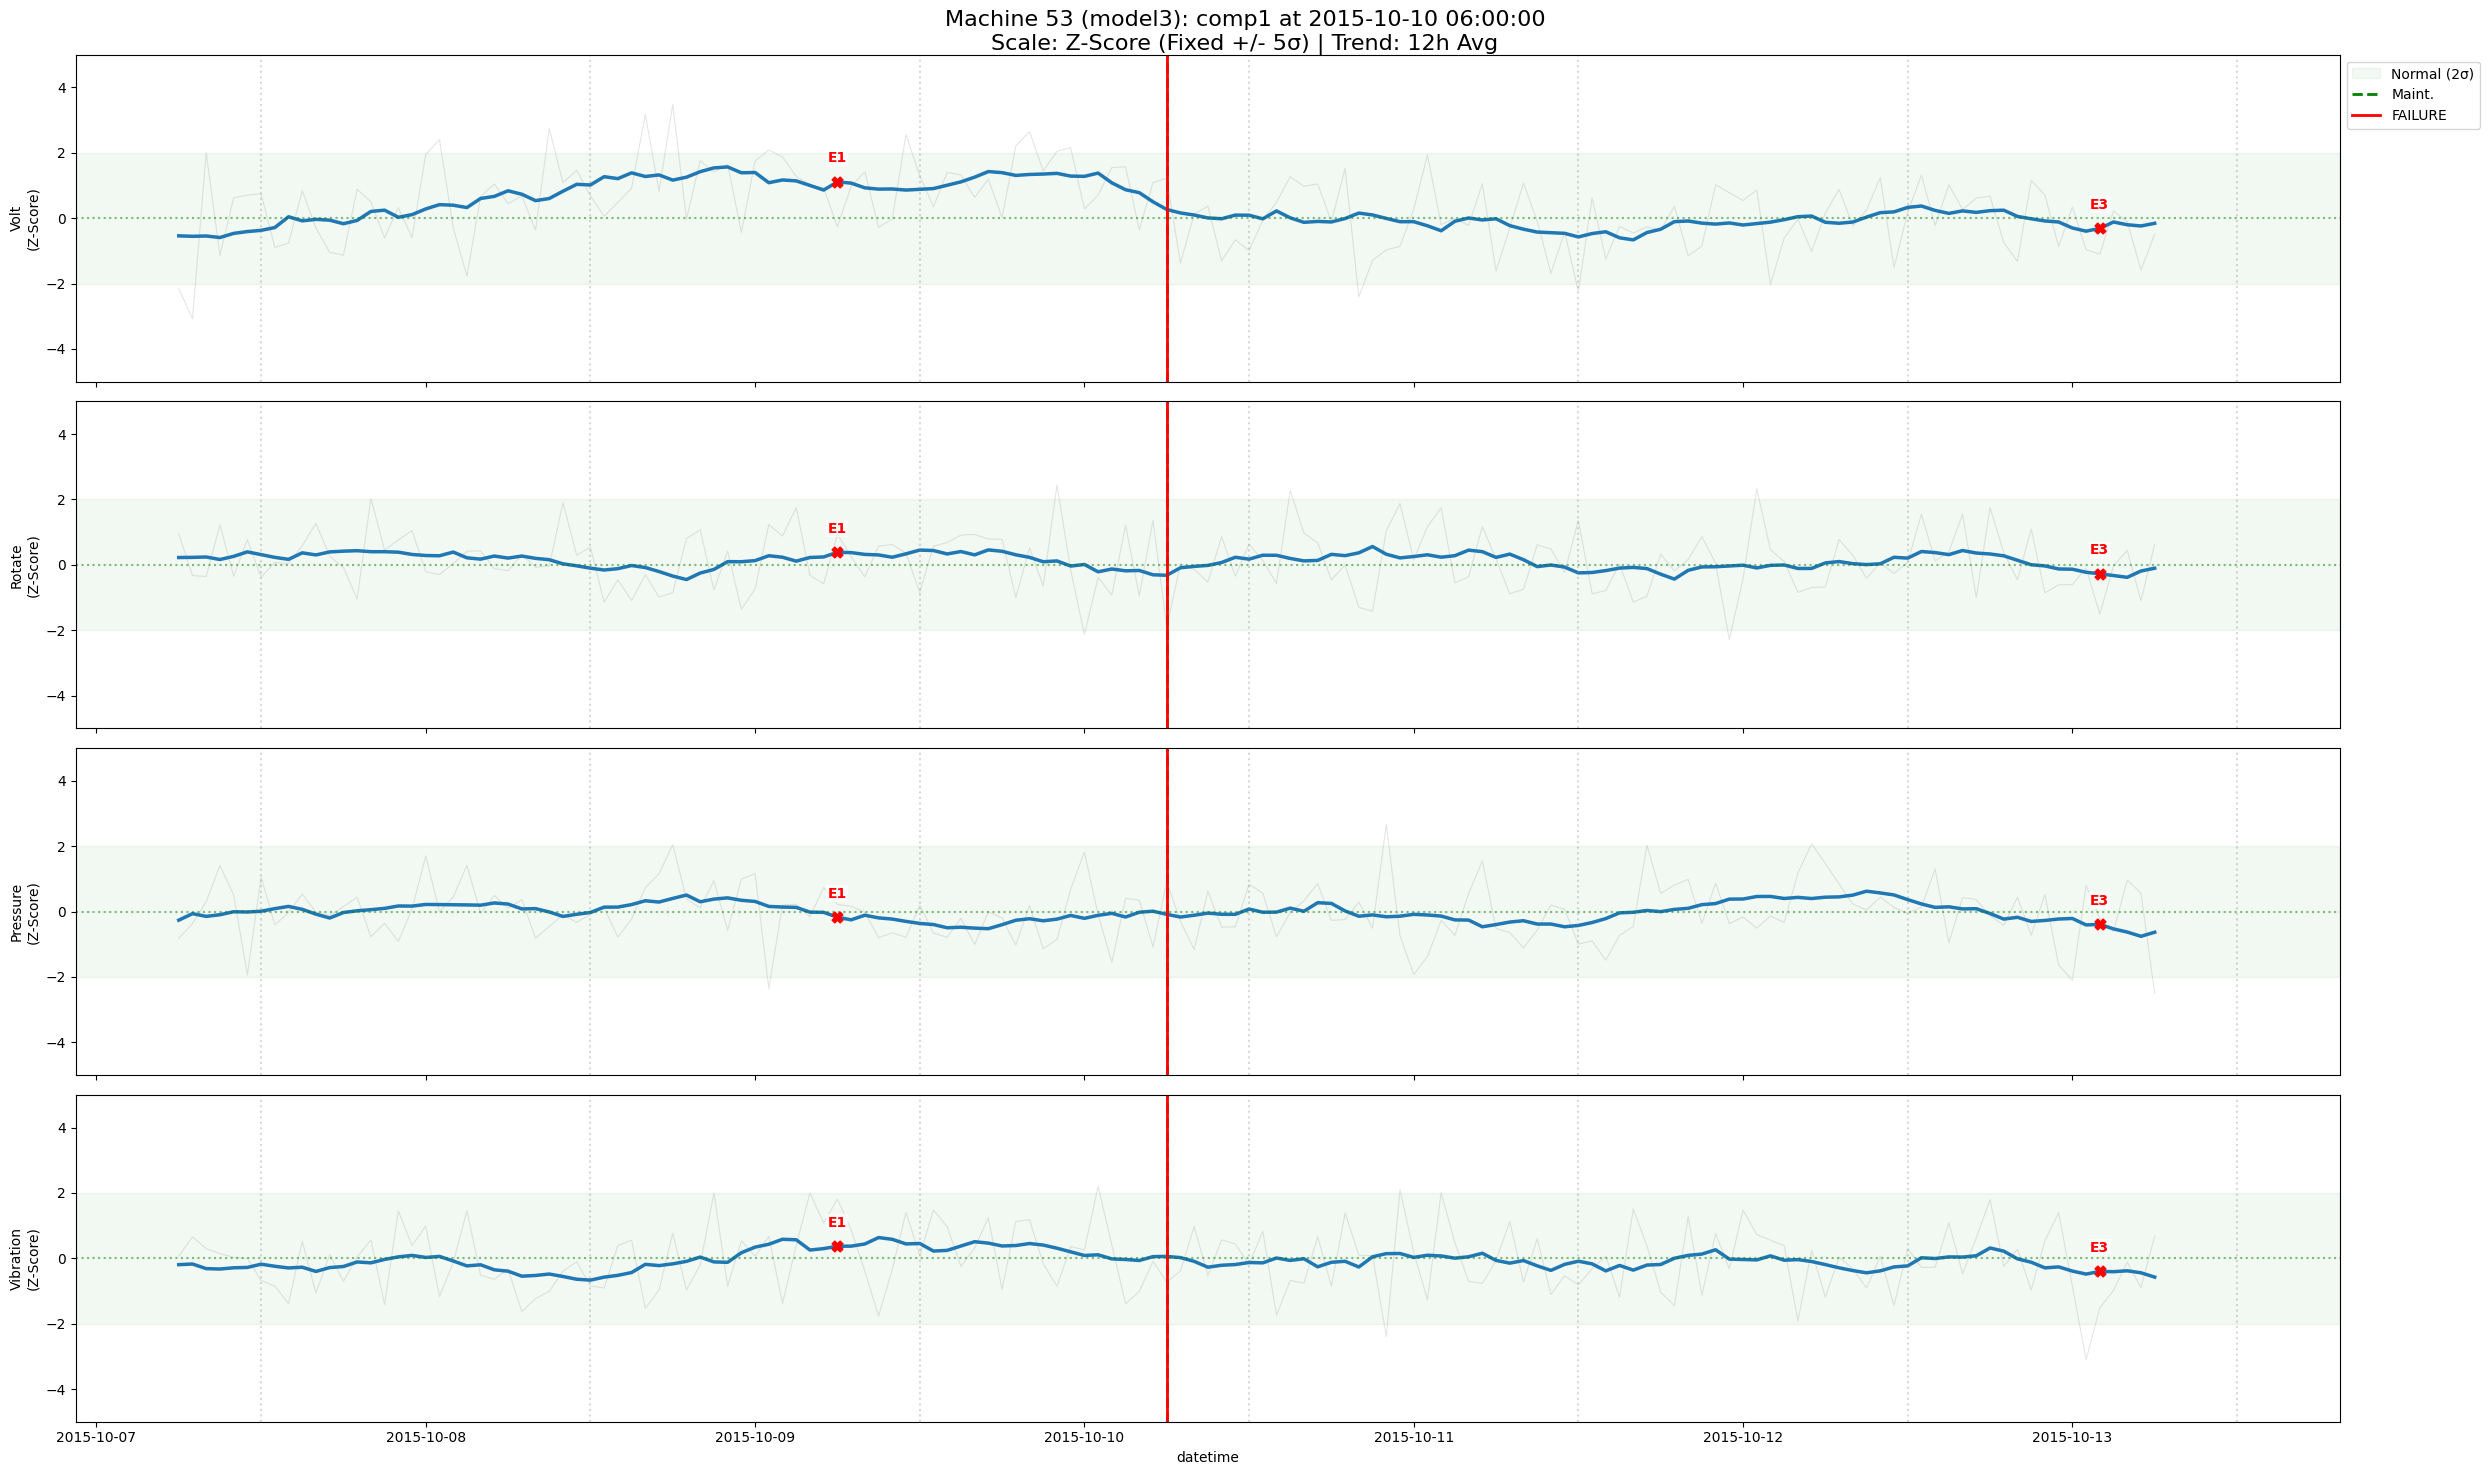



=== Visualizing for model3 - comp2 ===
Loading data...


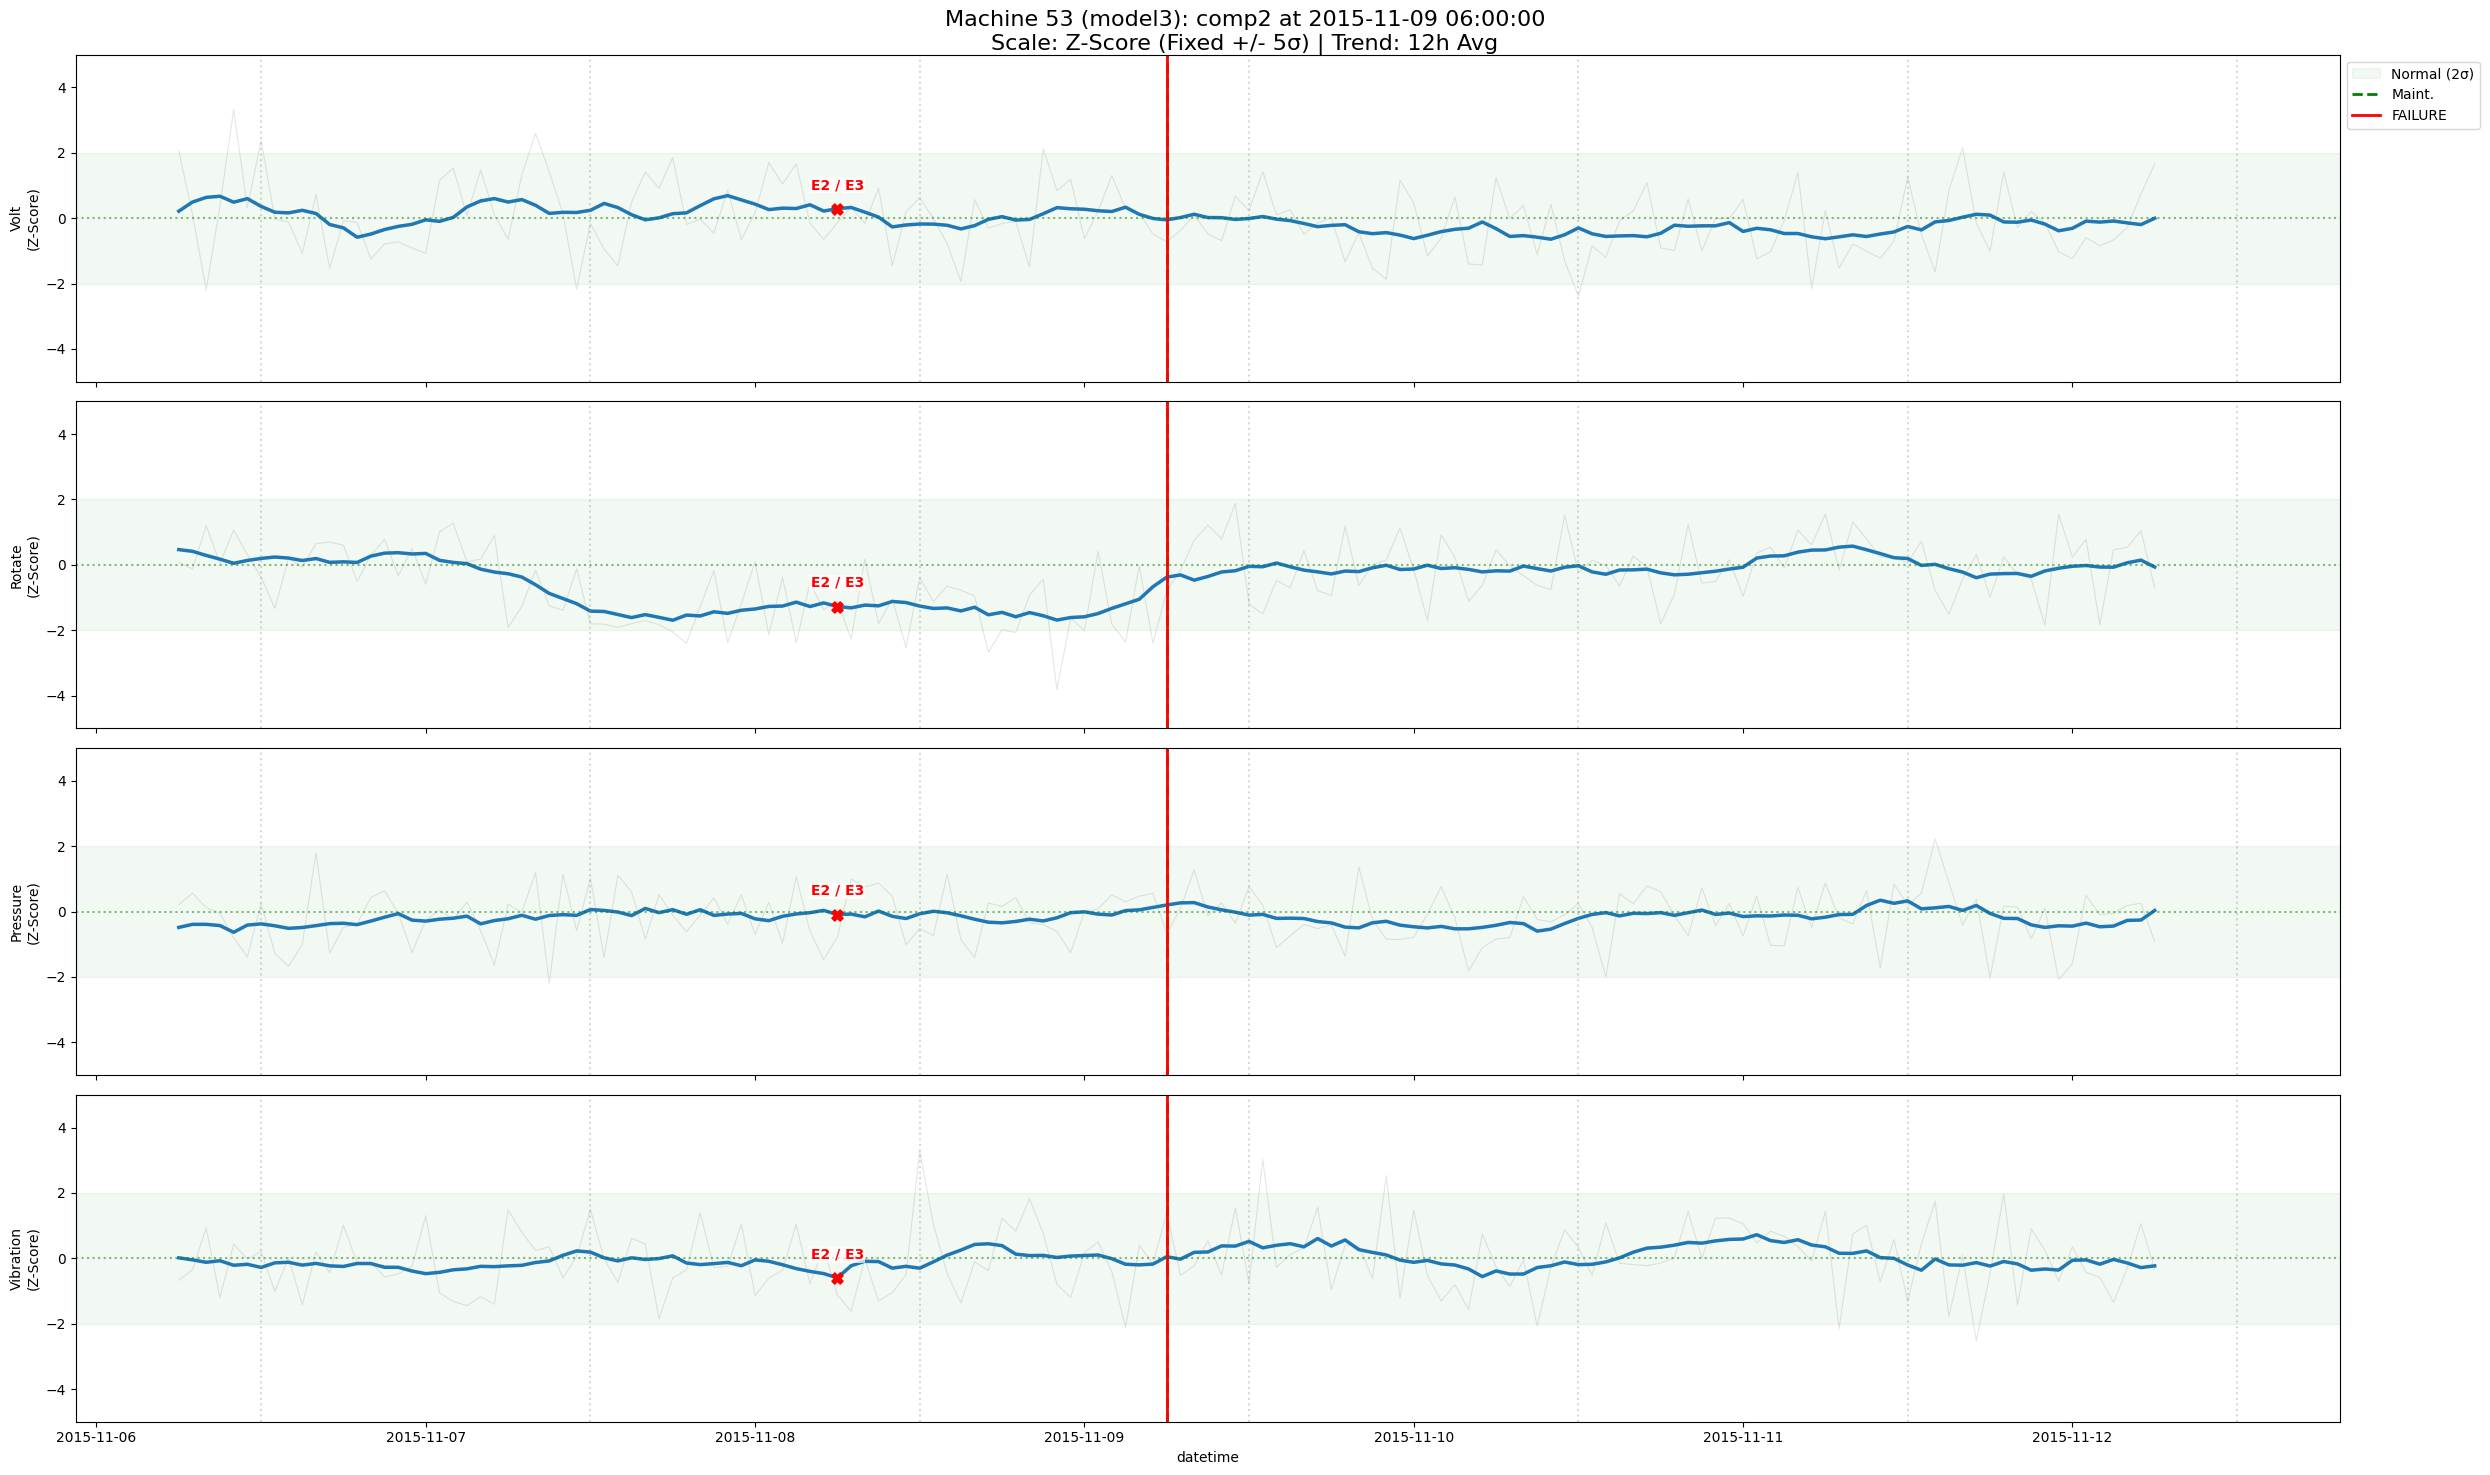



=== Visualizing for model3 - comp3 ===
Loading data...
No failures found.


=== Visualizing for model3 - comp4 ===
Loading data...


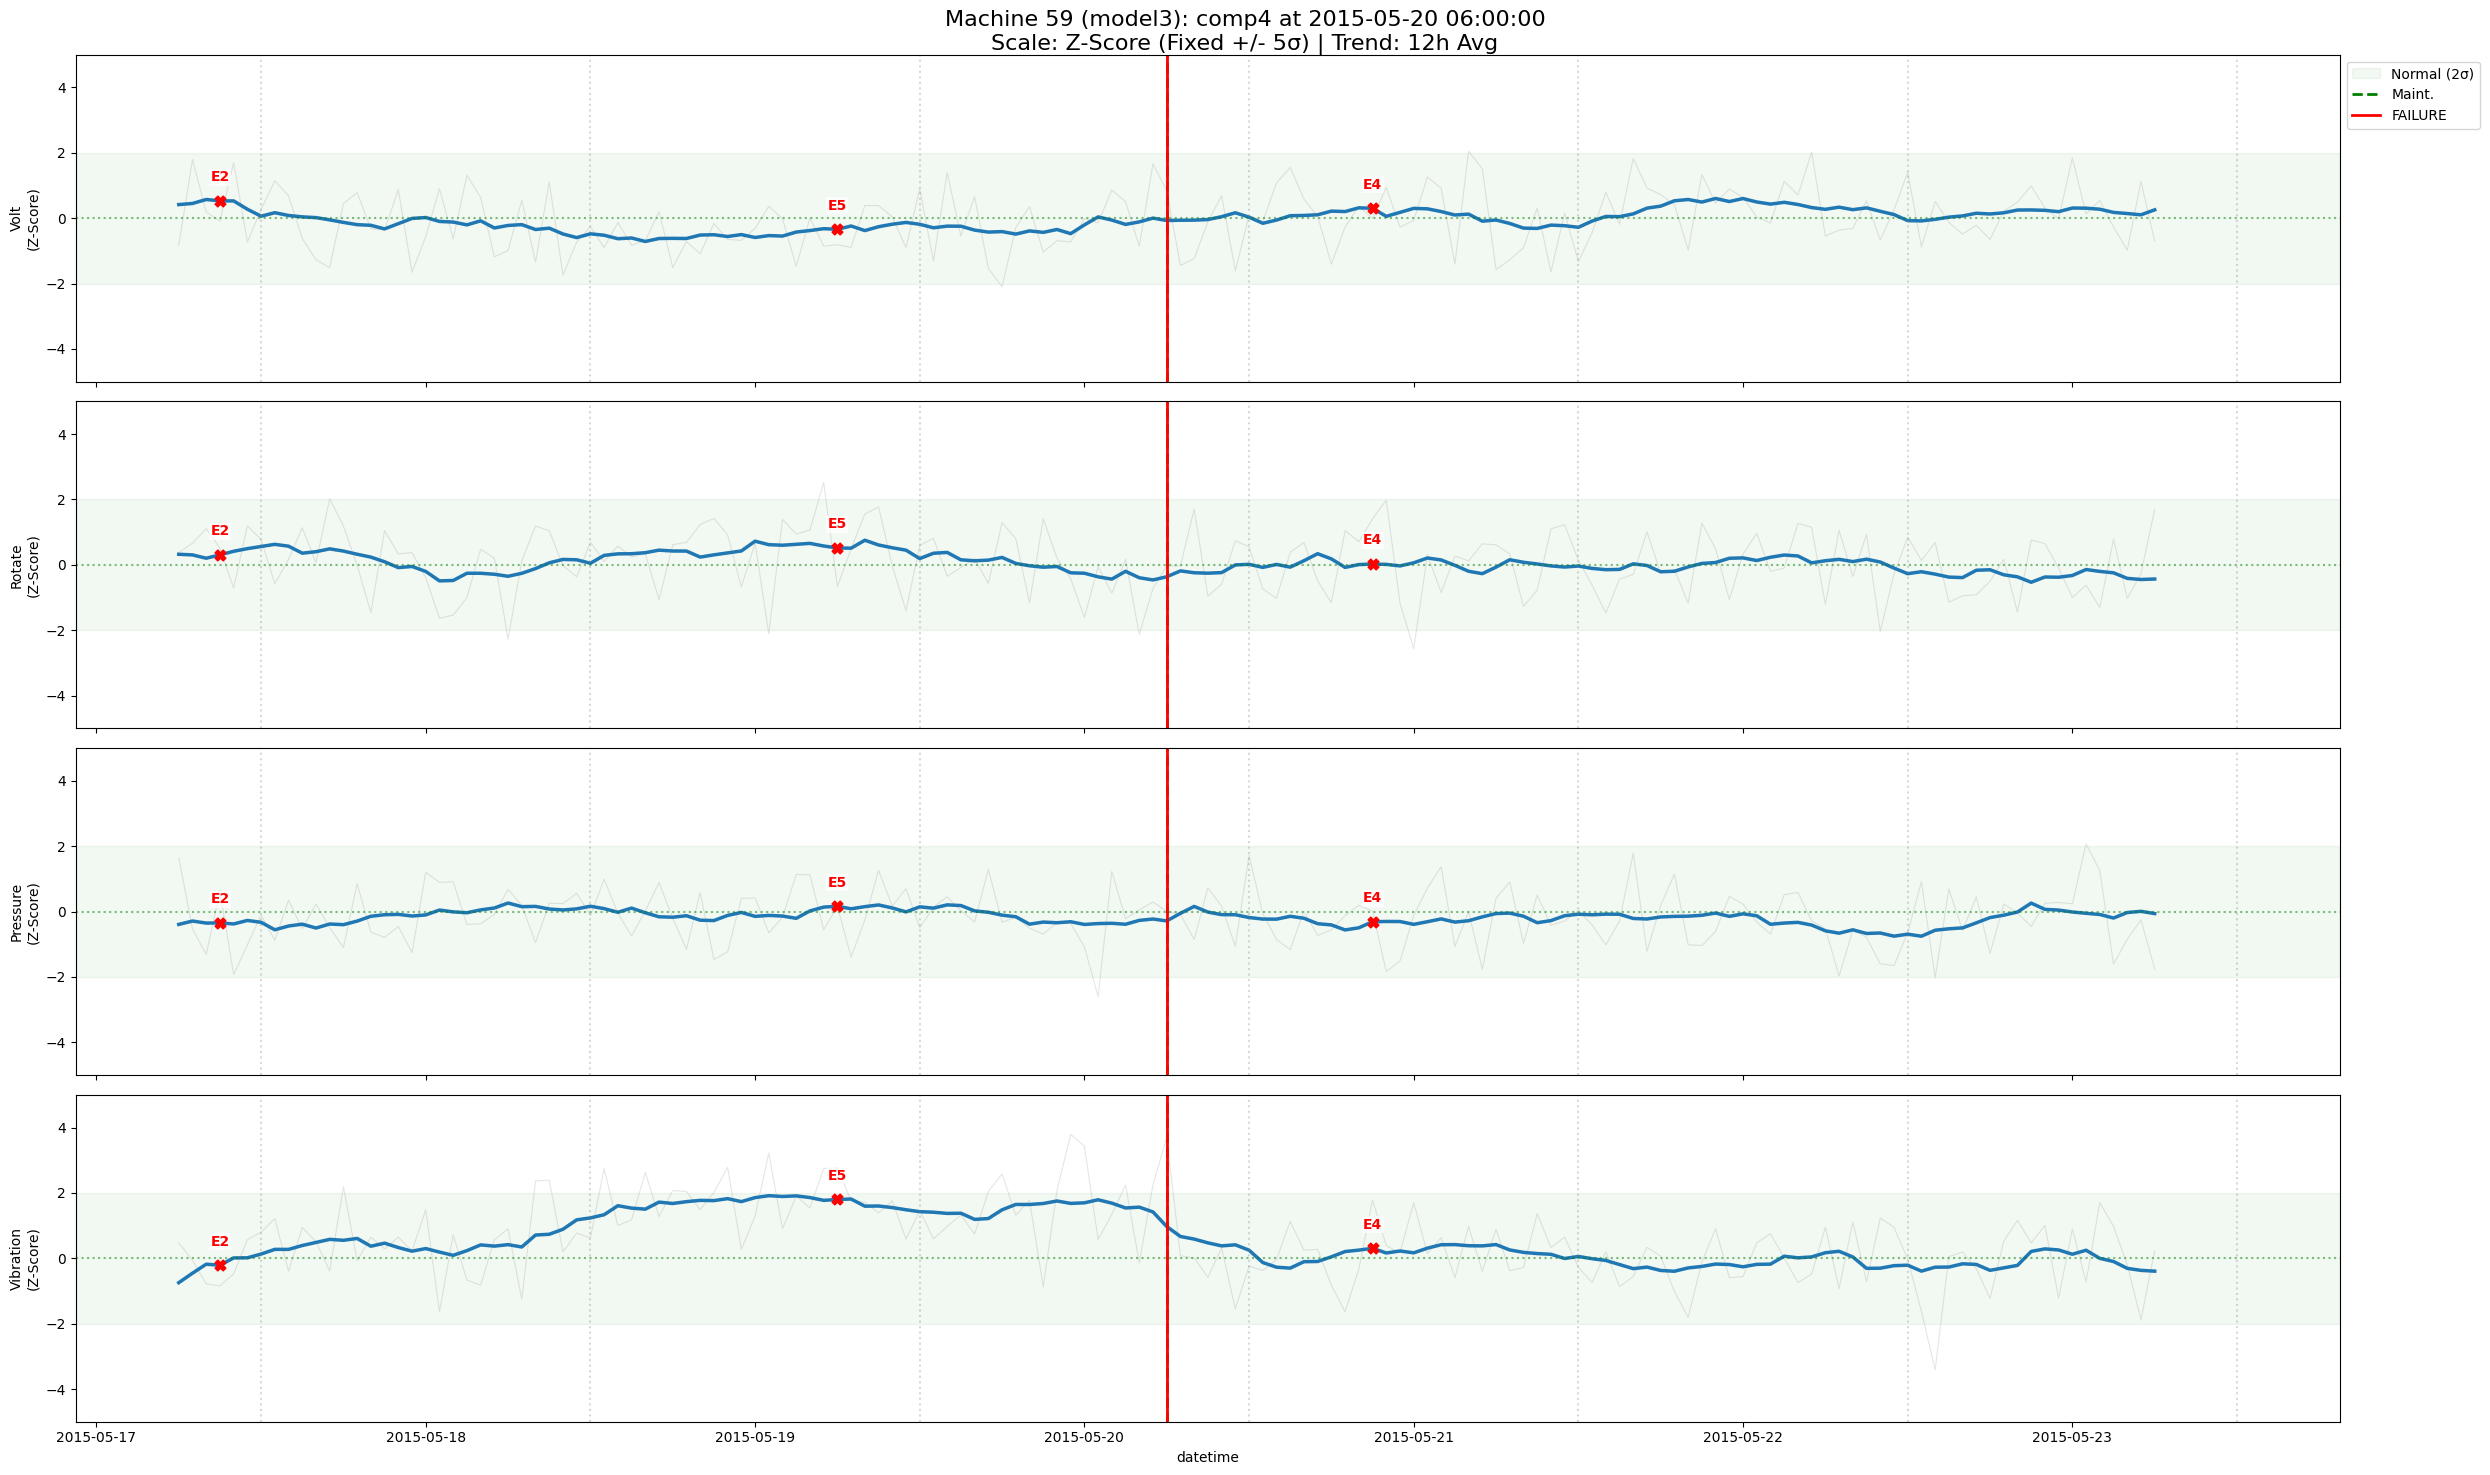



=== Visualizing for model4 - comp1 ===
Loading data...


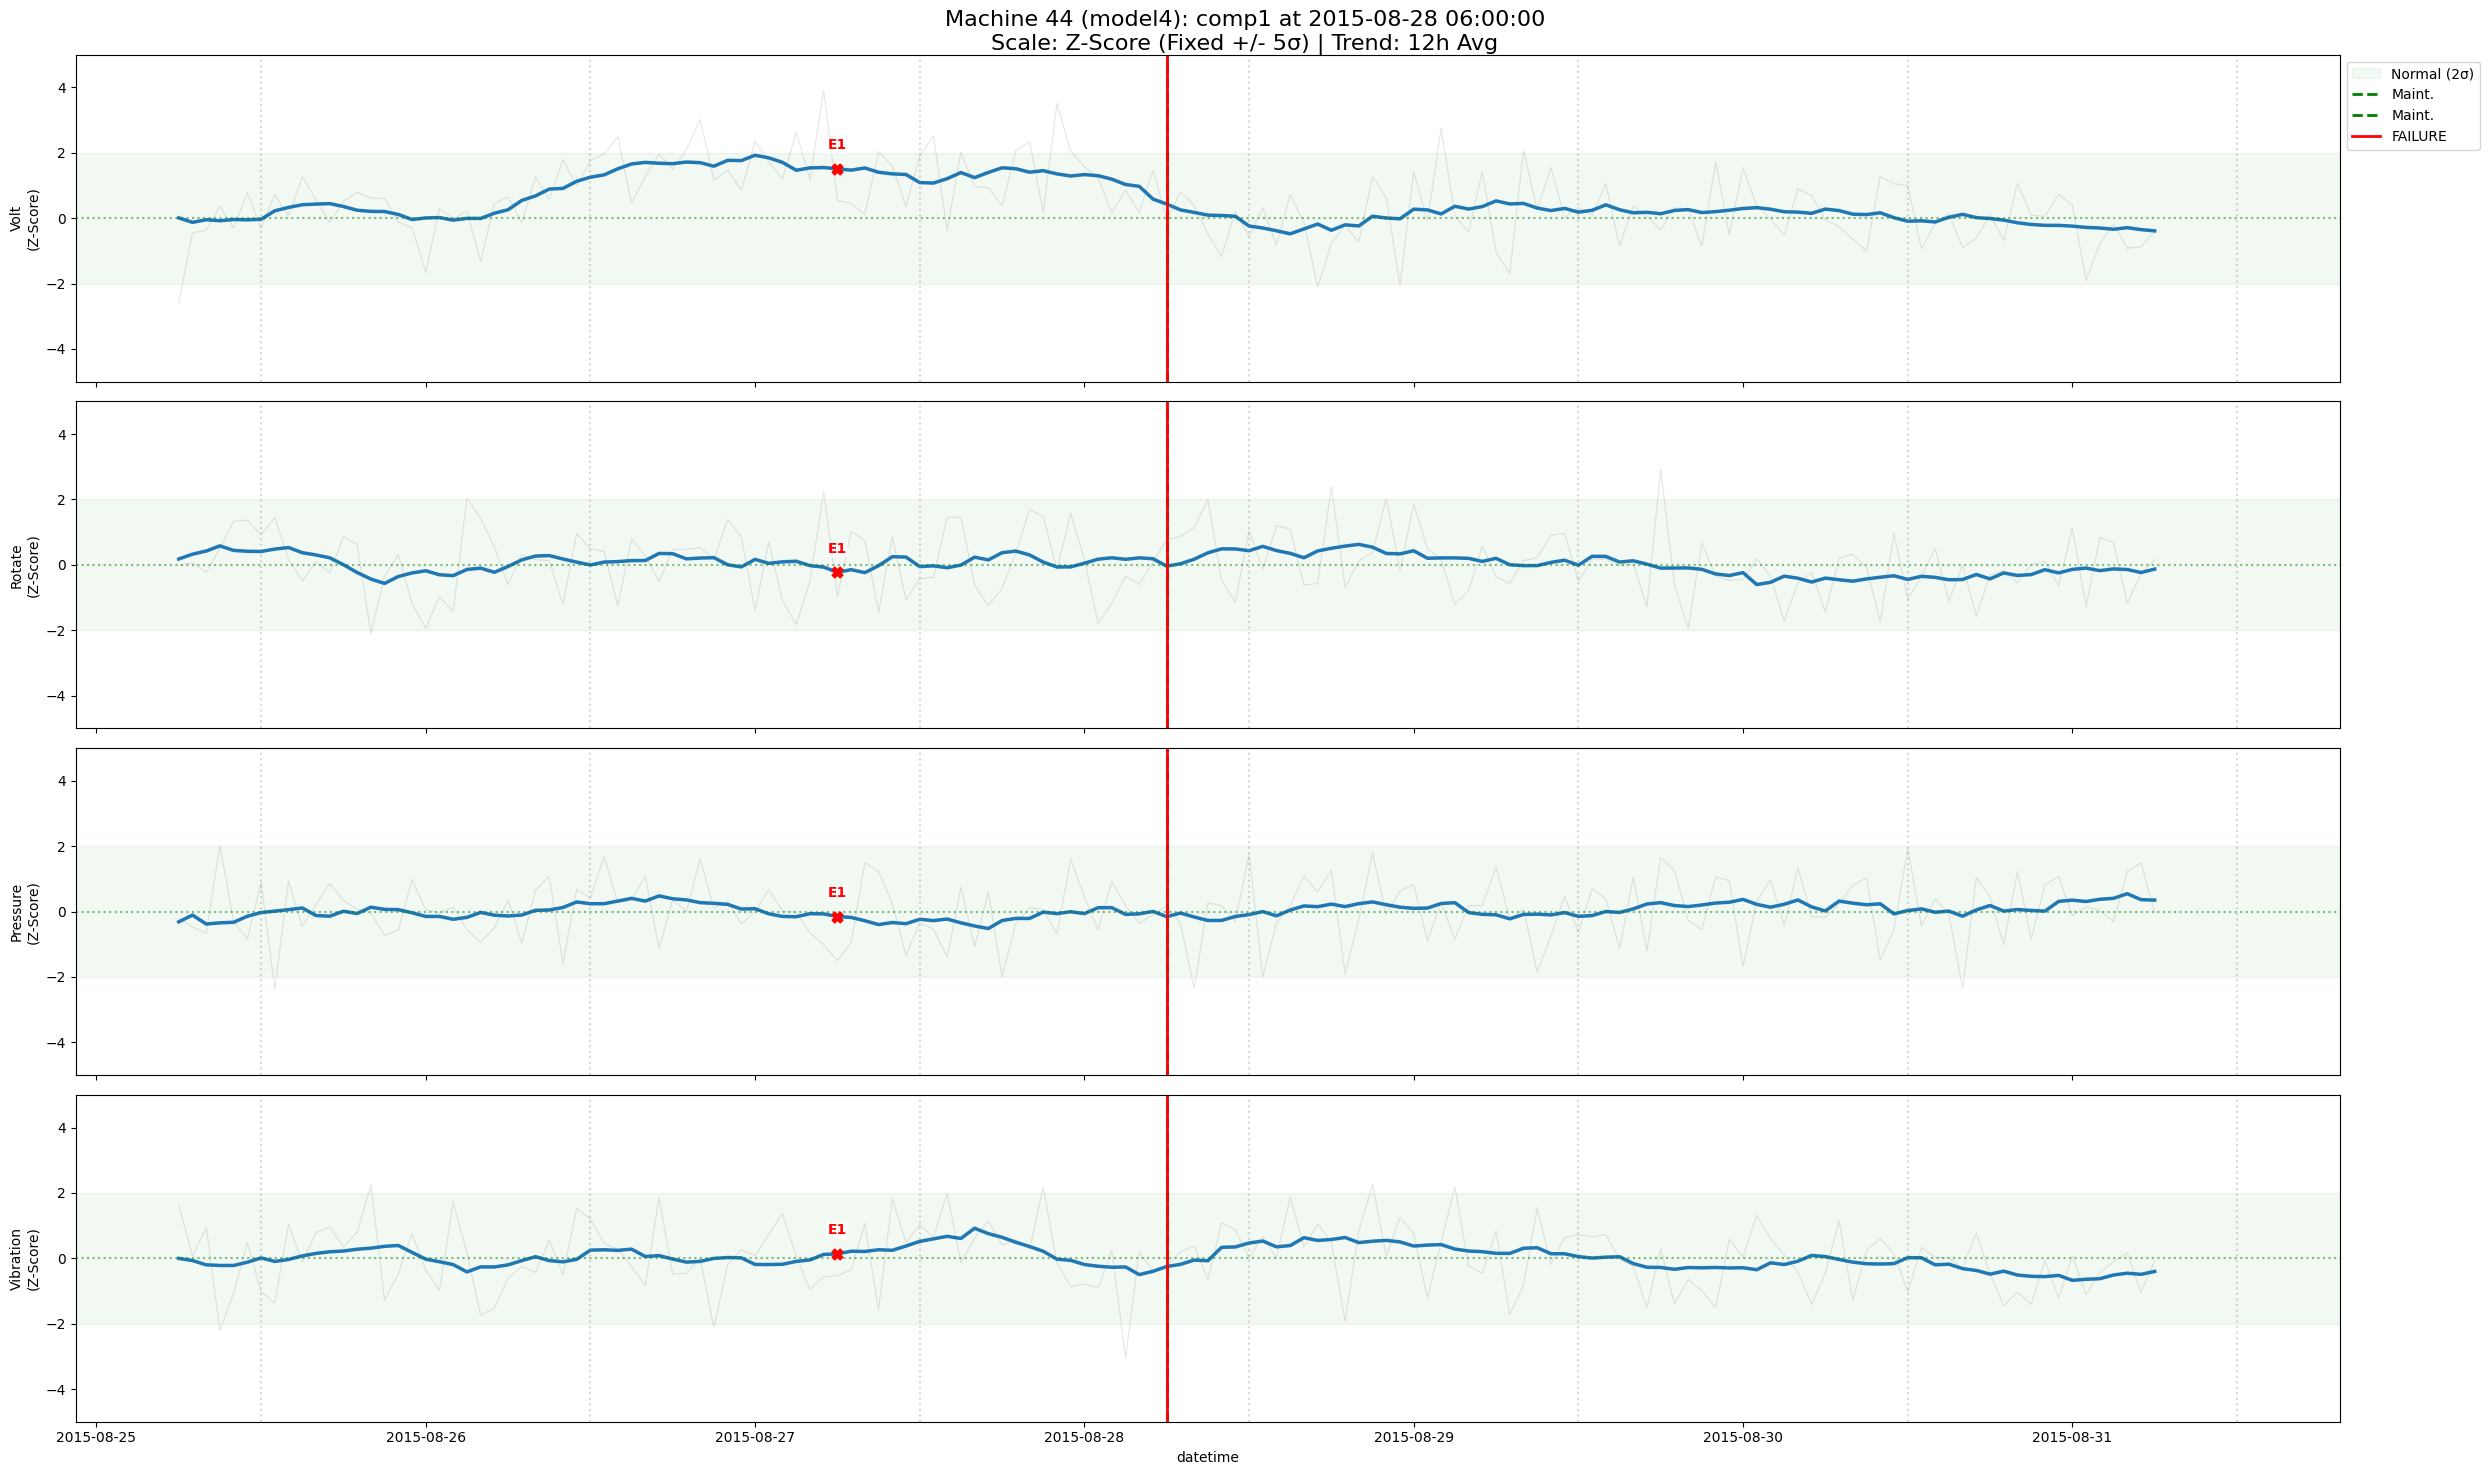



=== Visualizing for model4 - comp2 ===
Loading data...


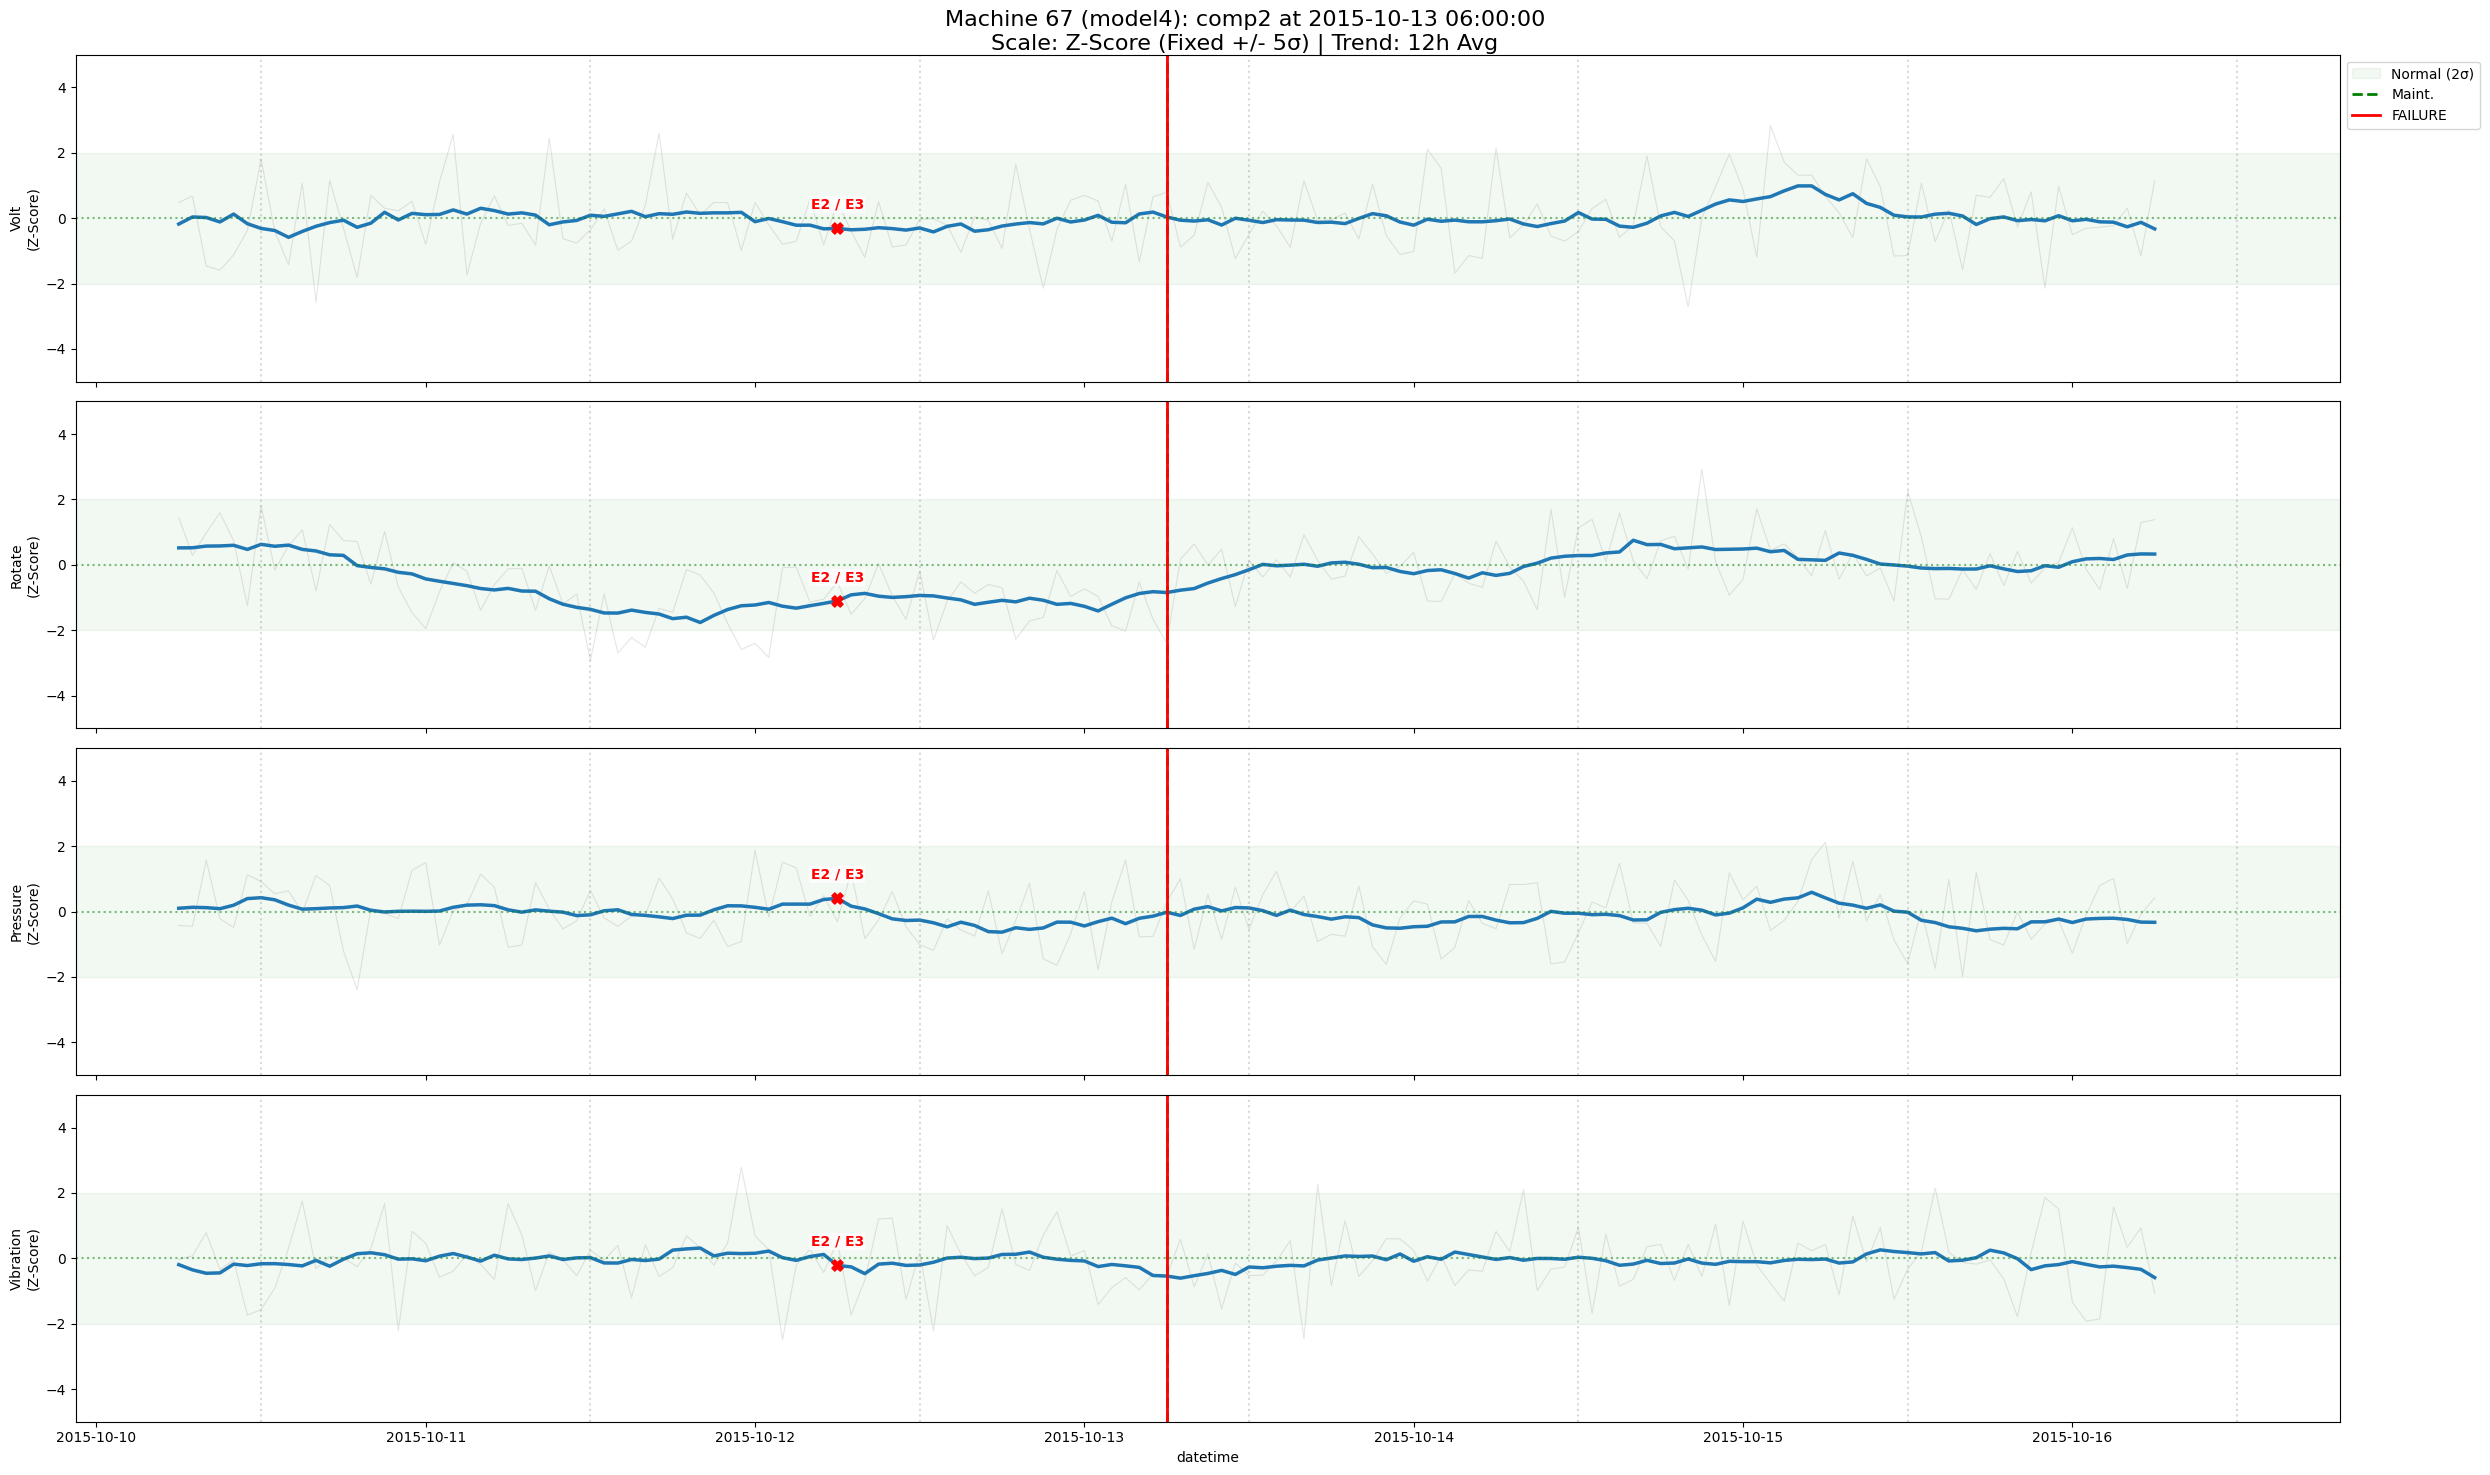



=== Visualizing for model4 - comp3 ===
Loading data...
No failures found.


=== Visualizing for model4 - comp4 ===
Loading data...


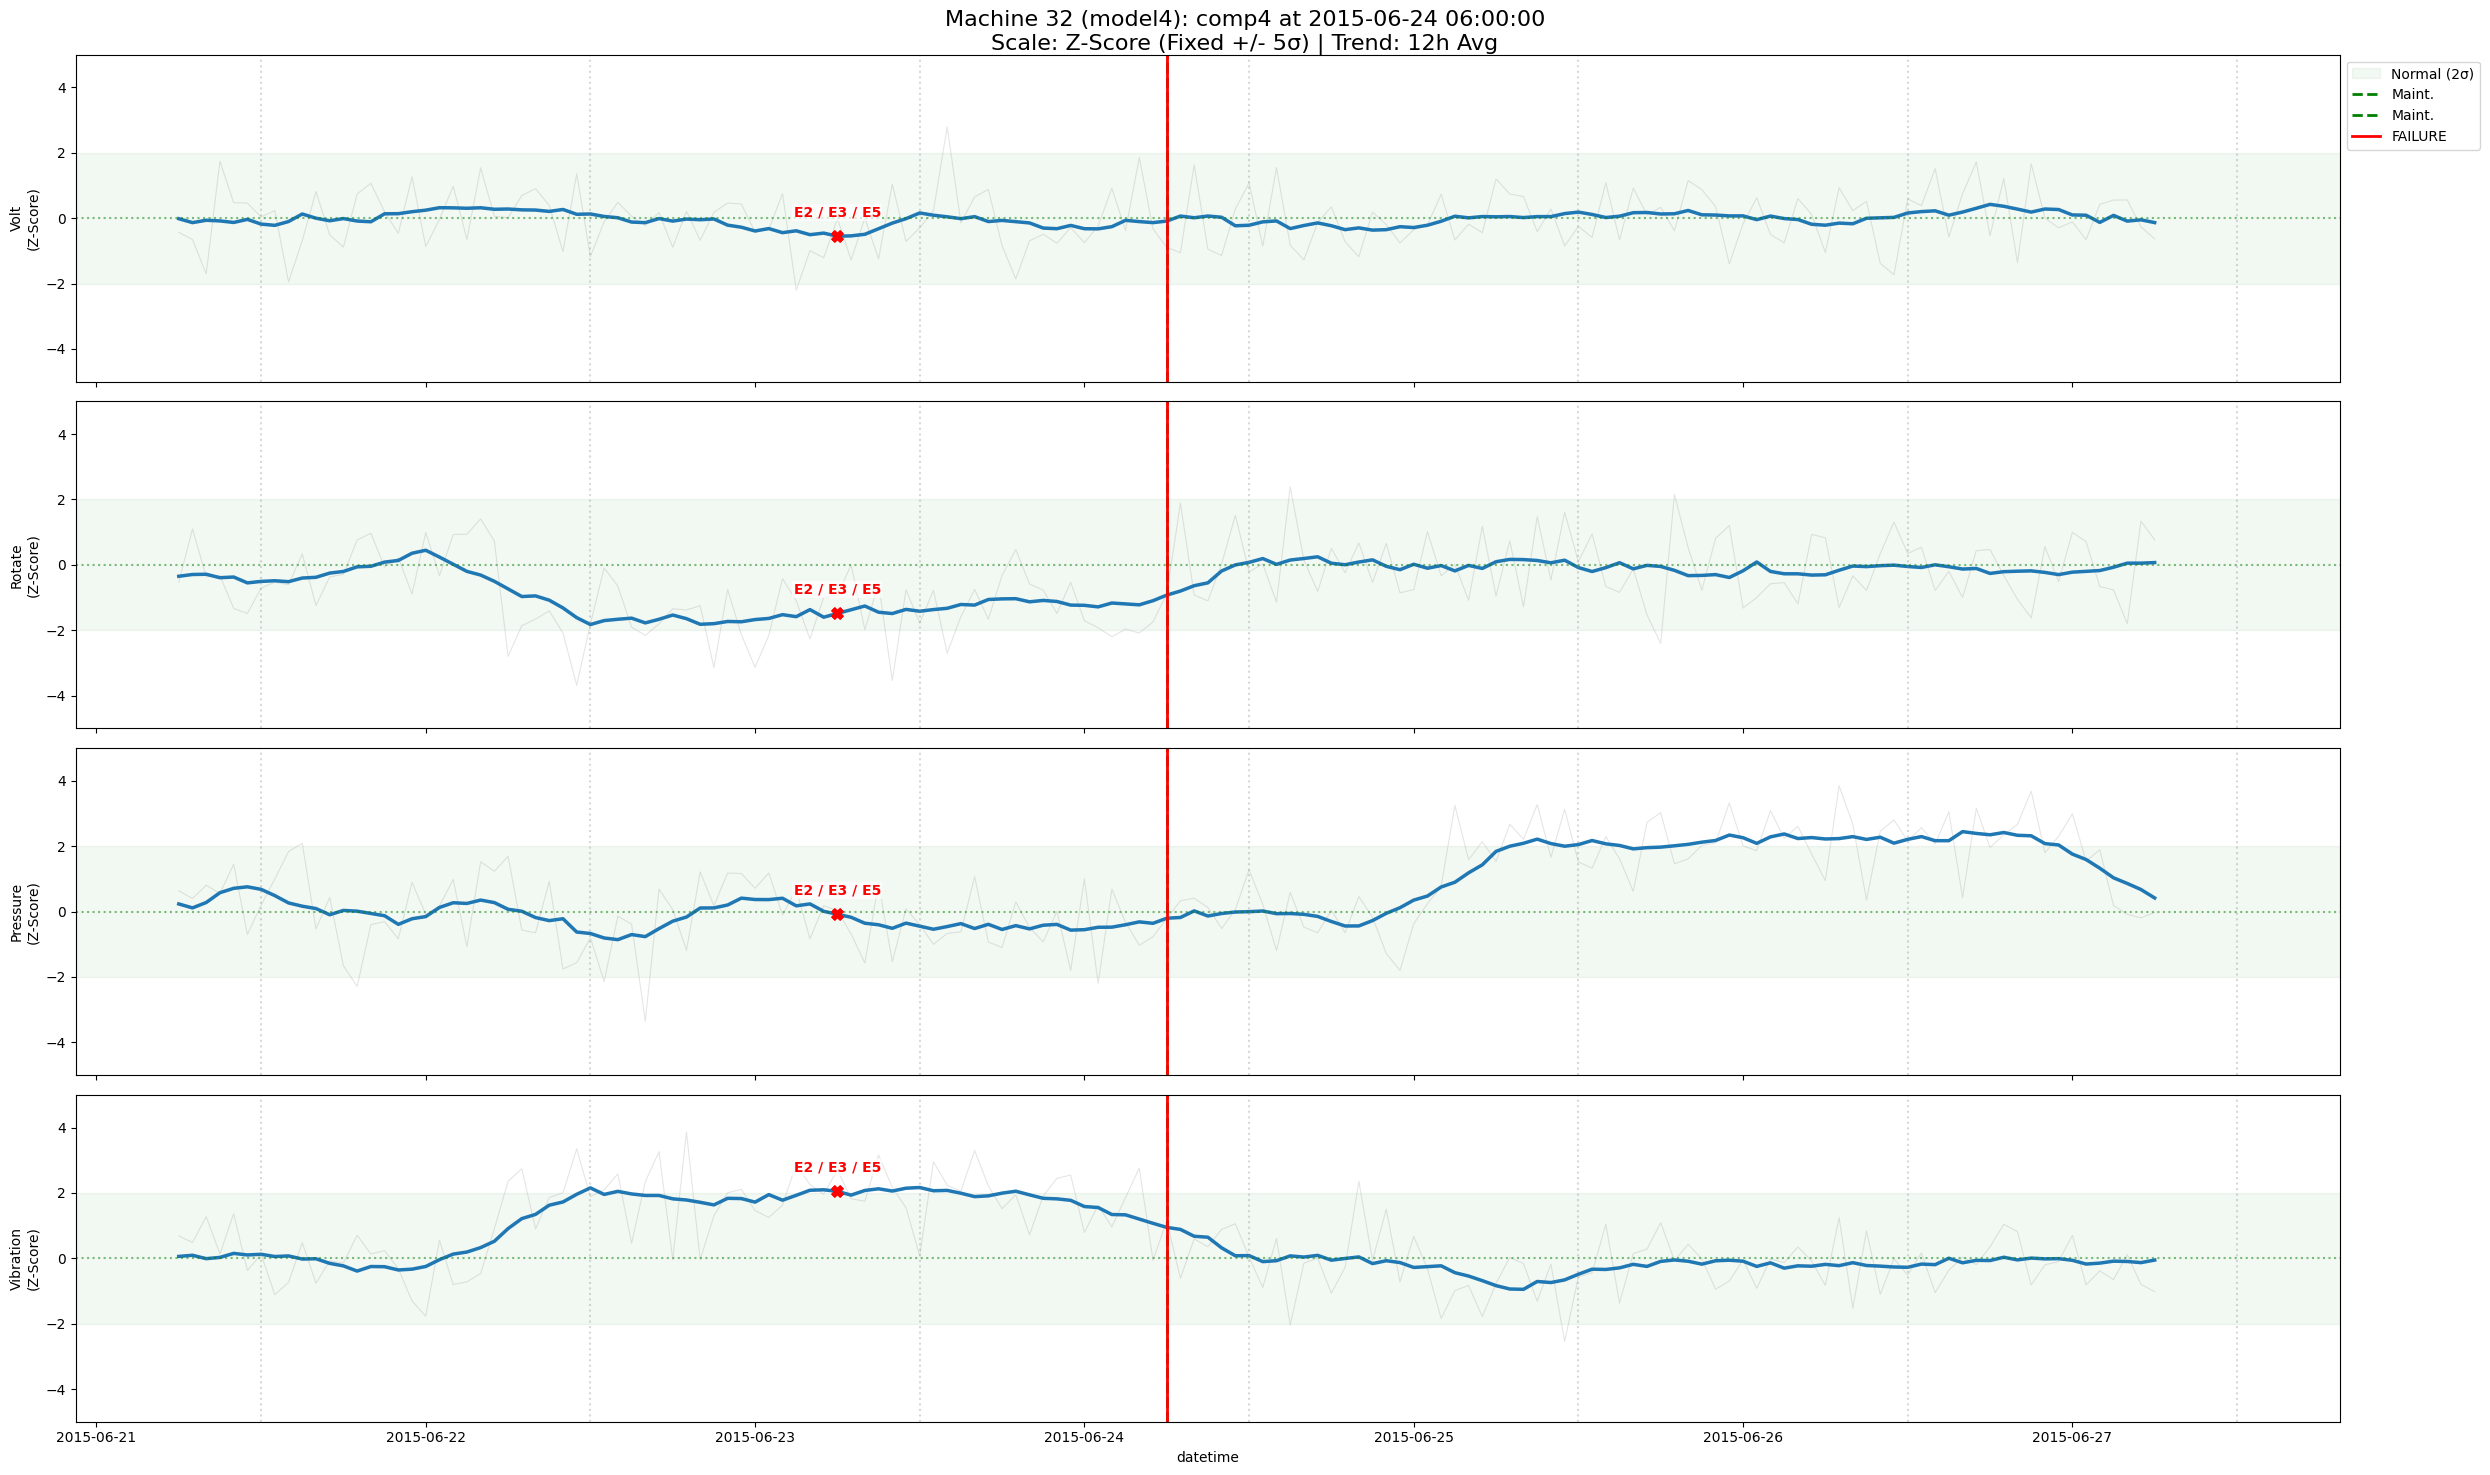

In [4]:
for model_type in ["model1", "model2", "model3", "model4"]:
    for failure_type in ["comp1", "comp2", "comp3", "comp4"]:
        print(f"\n\n=== Visualizing for {model_type} - {failure_type} ===")
        visualize_data(
            telemetry_path="./data/PdM_telemetry.csv",
            errors_path="./data/PdM_errors.csv",
            failures_path="./data/PdM_failures.csv",
            maint_path="./data/PdM_maint.csv",
            machines_path="./data/PdM_machines.csv",
            machine_model=model_type,
            failure_type=failure_type,
            window_hours=72,
            n_examples=1,
            ylim_sigma=5,
            smooth_window=12,
            scale=True
        )

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind


def analyze_precursors(df, window_hours=12):
    """
    Calculates the Z-score deviation of sensors before every failure type.
    """
    print(f"--- Scanning Physical Precursors (Window: {window_hours}h) ---")
    
    sensors = ["volt", "rotate", "pressure", "vibration"]
    failures = [c for c in df.columns if c.startswith("fail_")]
    
    heatmap_data = pd.DataFrame(index=failures, columns=sensors, dtype=float)
    p_values = pd.DataFrame(index=failures, columns=sensors, dtype=float)
    
    for fail_col in failures:
        fail_idxs = df[df[fail_col] == 1].index
        if len(fail_idxs) < 3: continue
            
        pre_fail_vals = {s: [] for s in sensors}
        
        for idx in fail_idxs:
            row = df.loc[idx]
            mid = row['machineID']
            dt = row['datetime']
            start_dt = dt - pd.Timedelta(hours=window_hours)
            
            mask = (df['machineID'] == mid) & (df['datetime'] >= start_dt) & (df['datetime'] < dt)
            window = df.loc[mask]
            
            if len(window) > 0:
                for s in sensors:
                    pre_fail_vals[s].extend(window[s].values)
        
        for s in sensors:
            pf = np.array(pre_fail_vals[s])
            if len(pf) < 10: continue
            
            global_mean = df[s].mean()
            global_std = df[s].std()
            
            z_score_diff = (pf.mean() - global_mean) / global_std
            
            global_sample = df[s].sample(n=min(len(df), 10000)).values
            _, p = ttest_ind(pf, global_sample, equal_var=False)
            
            heatmap_data.loc[fail_col, s] = z_score_diff
            p_values.loc[fail_col, s] = p

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data.fillna(0), annot=True, cmap="RdBu_r", center=0, fmt=".2f")
    plt.title(f"Precursor Anomaly Strength ({window_hours}h Pre-Failure)\nPositive = High, Negative = Low")
    plt.ylabel("Failure Type")
    plt.xlabel("Sensor")
    plt.tight_layout()
    plt.show()
    
    return heatmap_data

In [6]:
df = load_and_merge_pdm_from_dir("./data")

--- Scanning Physical Precursors (Window: 12h) ---


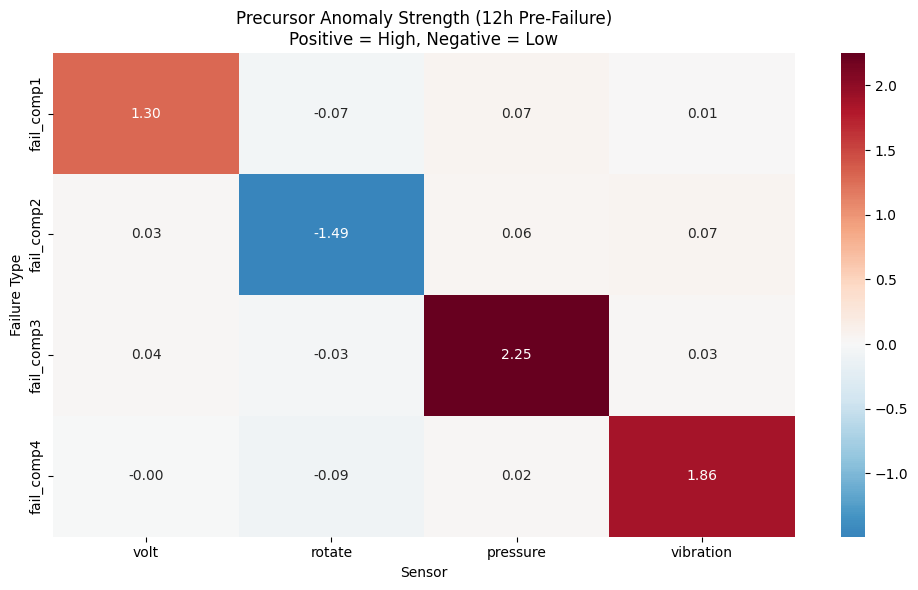

volt    rotate  pressure  vibration
fail_comp1  1.295455 -0.070733  0.067663   0.010596
fail_comp2  0.027755 -1.490641  0.057279   0.072454
fail_comp3  0.042048 -0.031447  2.250190   0.031015
fail_comp4 -0.004675 -0.089440  0.022270   1.857241

In [7]:
analyze_precursors(df)

In [8]:
from aggregate_and_eval import (
    aggregate_graphs_by_algorithm,
    prune_graph,
    evaluate_telemetry_failure_edges,
    plot_telemetry_failure_heatmap,
    get_edge_comparison,
    print_summary_statistics,
    save_aggregated_graphs
)

Aggregating 7 algorithms (min_frequency=0.0%)...
  cbnb_e_mixed: 0 edges (0 before pruning), 0 machines
  cbnb_w_mixed: 240 edges (240 before pruning), 63 machines
  gcmvl_mixed: 37 edges (37 before pruning), 73 machines
  nbcb_e_mixed: 0 edges (0 before pruning), 0 machines
  nbcb_w_mixed: 246 edges (246 before pruning), 62 machines
  pcmci_mixed: 121 edges (121 before pruning), 73 machines
  varlingam_mixed: 142 edges (142 before pruning), 62 machines

Evaluating 4 ground truth telemetry→failure edges:
  volt → fail_comp1
  rotate → fail_comp2
  pressure → fail_comp3
  vibration → fail_comp4

SUMMARY: Telemetry→Failure Edge Discovery
      algorithm  n_discovered  avg_frequency  total_edges  recall
   cbnb_w_mixed             4       0.365079            4     1.0
   nbcb_w_mixed             4       0.580645            4     1.0
    pcmci_mixed             4       0.181507            4     1.0
varlingam_mixed             4       0.173387            4     1.0
   cbnb_e_mixed           

(<Figure size 1000x600 with 2 Axes>,
 <Axes: title={'center': 'Discovery of Known Telemetry→Failure Relationships\nFrequency across all machines'}, xlabel='Telemetry → Failure Edge', ylabel='Algorithm'>)

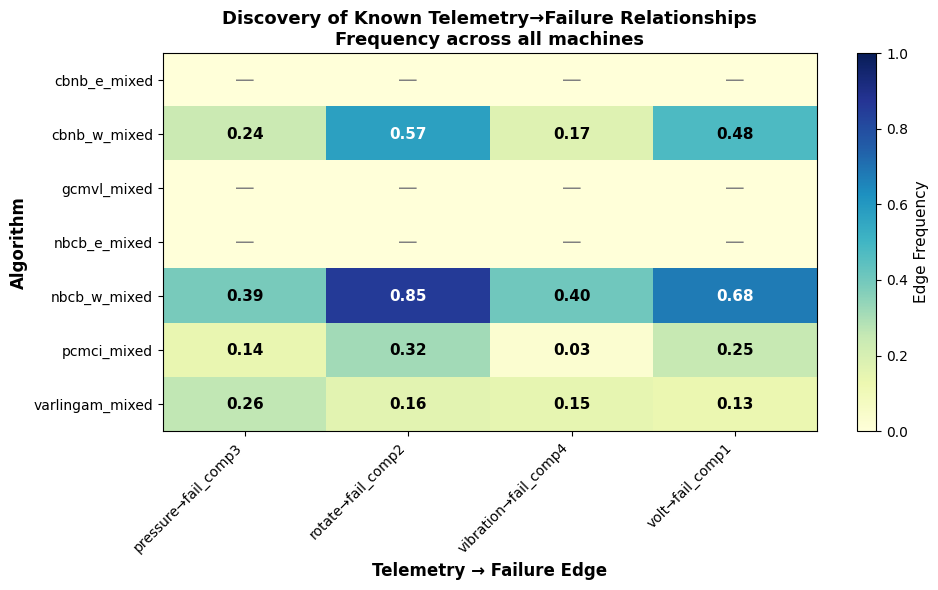

In [21]:
agg_all = aggregate_graphs_by_algorithm(min_frequency=0)
eval_df = evaluate_telemetry_failure_edges(agg_all)
plot_telemetry_failure_heatmap(eval_df)

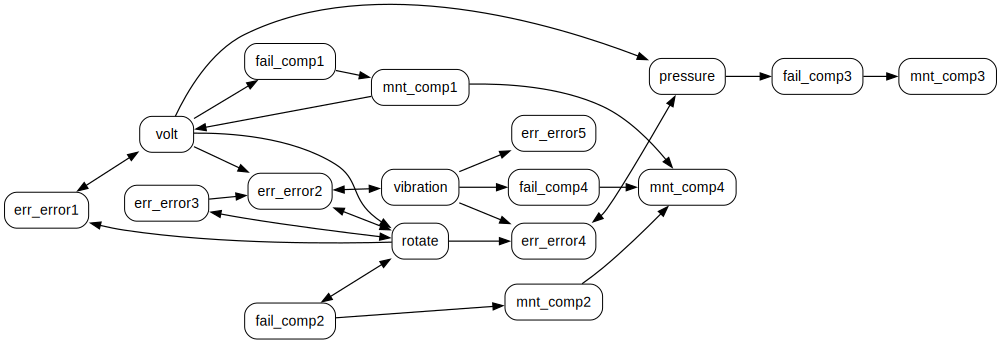

In [26]:
from graphs import dict_to_generalgraph, draw_generalgraph

nbcb_w = agg_all["nbcb_w_mixed"]
nbcb_w = prune_graph(nbcb_w, 0.35)
g = dict_to_generalgraph(nbcb_w)
draw_generalgraph(g, title="")